In [49]:
import cv2
import os
from collections import Counter, defaultdict
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from scipy.special import logsumexp

# Path to the dataset

In [2]:
dataset_path = '/kaggle/input/att-database-of-faces'

# Read images

X shape: (400, 10304)
y shape: (400,)


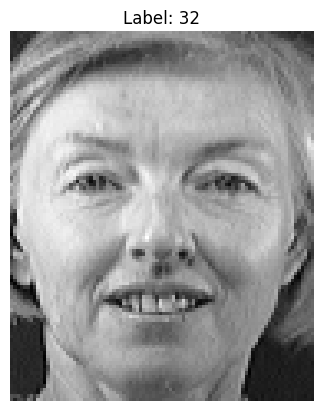

In [3]:
images = []
labels = []

for person_dir in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_dir)
    if os.path.isdir(person_path):
        label = int(person_dir[1:])
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            # Grayscale images of shape (112, 92)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Flatten the image to be has shape (112 * 92 -> 10304, )
            img_flattened = img.flatten()
            images.append(img_flattened)
            labels.append(label)

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Get the shape of the dataset and its label
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Show one image
plt.imshow(X[0].reshape(112, 92), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

# Split data into training and testing data 

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

m,_ = X.shape
for i in range(0, m-1, 2):
    X_train.append(X[i])
    y_train.append(y[i])
    X_test.append(X[i+1])
    y_test.append(y[i+1])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Get the shape of the splited dataset and its label
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (200, 10304)
y_train shape: (200,)
X_test shape: (200, 10304)
y_test shape: (200,)


In [5]:
# Make fixed random seed

y_train = np.array(y_train).reshape(-1, 1)
train_data = np.hstack((X_train, y_train))

y_test = np.array(y_test).reshape(-1, 1)
test_data = np.hstack((X_test, y_test))

np.random.seed(42)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# Get the shape of the splited dataset and its label
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (200, 10304)
y_train shape: (200,)
X_test shape: (200, 10304)
y_test shape: (200,)


# PCA

In [6]:
class PCA:
    def __init__(self, n_components=None, alpha=None):
        """
        Parameters:
        - n_components: int, number of components to keep
        - alpha: float (0-1), minimum variance ratio to retain
        """
        self.n_components = n_components
        self.alpha = alpha
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None
    
    def fit(self, X):
        # 1. Standardize the data (center to mean)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Save/load eigenvalues and eigenvectors
        if os.path.exists('eigenvalues.npy') and os.path.exists('eigenvectors.npy'):
            self.eigenvalues = np.load('eigenvalues.npy')
            self.eigenvectors = np.load('eigenvectors.npy')
        else:
            cov_matrix = np.cov(X_centered, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eigenvalues)[::-1]
            self.eigenvalues = eigenvalues[sorted_indices]
            self.eigenvectors = eigenvectors[:, sorted_indices]
            
            np.save('eigenvalues.npy', self.eigenvalues)
            np.save('eigenvectors.npy', self.eigenvectors)
        
        # 5. Compute explained variance ratio ??
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance
        
        # 6. Determine number of components to keep 
        if self.alpha is not None:
            cumulative_variance = np.cumsum(self.explained_variance_ratio)
            self.n_components = np.argmax(cumulative_variance >= self.alpha) + 1
        
        # 7. Select top components with max eigenvalue
        self.components = self.eigenvectors[:, :self.n_components] ## using in inverse transform
        
        return self
    
    def transform(self, X):
        # Center the data using the mean from training
        X_centered = X - self.mean
        
        # Project data onto principal components
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [7]:
def apply_pca(X_train, X_test, alpha=0.9): ## default with 99%
    """"
    make a pojection for x_test  not need to fit but train must fit then make a projuction
    make a fit transform for x_train 

    """
    pca = PCA(alpha=alpha)  
    X_train_pca = pca.fit_transform(X_train)  
    X_test_pca = pca.transform(X_test) 
    return X_train_pca, X_test_pca, pca

In [8]:
# Apply PCA with different thresholds
alphas = [0.8, 0.85, 0.9, 0.95] ## the information needed to keep from pca taining 
pca_results = {}

for alpha in alphas:
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, alpha)
    pca_results[alpha] = {
        'train': X_train_pca,
        'test': X_test_pca,
        'pca': pca,
        'n_components': pca.n_components,  # Fixed: no underscore
        'explained_variance': pca.explained_variance_ratio  # Fixed: no underscore
    }
    print(f"Alpha: {alpha}, Components: {pca.n_components}, Explained Variance: {np.sum(pca.explained_variance_ratio):.4f}")

Alpha: 0.8, Components: 35, Explained Variance: 1.0000
Alpha: 0.85, Components: 51, Explained Variance: 1.0000
Alpha: 0.9, Components: 75, Explained Variance: 1.0000
Alpha: 0.95, Components: 114, Explained Variance: 1.0000


## vesualization some PCAs as vector

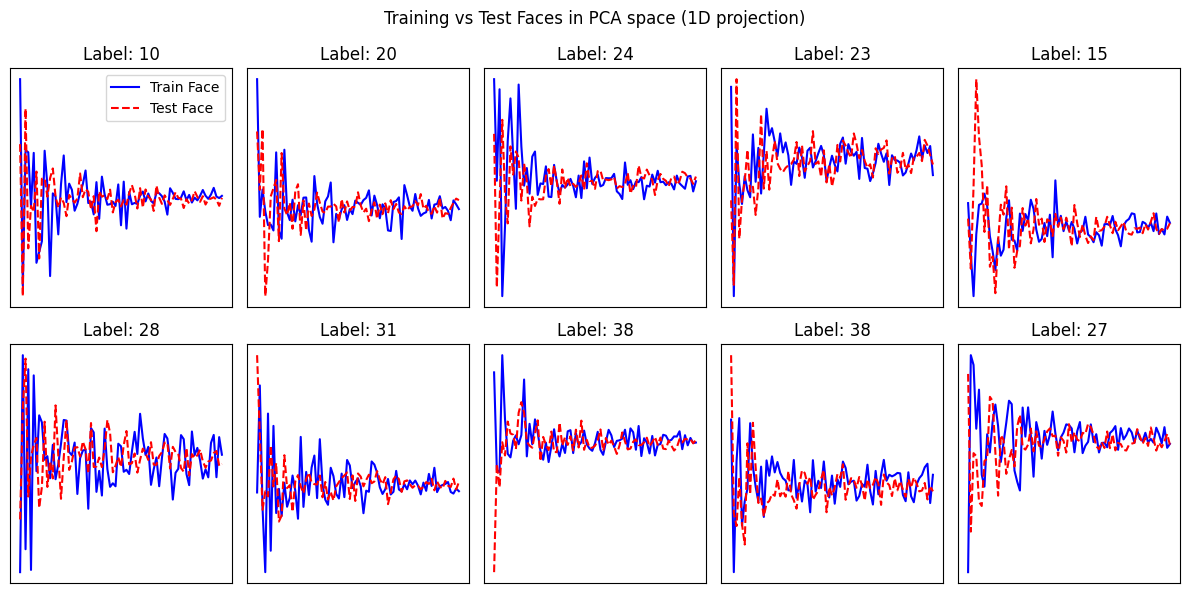

In [9]:
# every point refare to image in pca space compare to a unreduced dimentionality space
# Visualize few faces: each plot shows the training face and the corresponding test face
def visualize_faces(X_train_pca, X_test_pca, y_labels, n_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples//2, i+1)
        
        train_face = X_train_pca[i]
        test_face = X_test_pca[i]
        
        ax.plot(train_face, label="Train Face", color='blue')
        ax.plot(test_face, label="Test Face", color='red', linestyle='dashed')
        
        ax.set_title(f"Label: {y_labels[i]}")
        plt.xticks([])
        plt.yticks([])
        
        if i == 0:
            ax.legend()

    plt.suptitle('Training vs Test Faces in PCA space (1D projection)')
    plt.tight_layout()
    plt.show()

# Example: visualize first 10 faces for alpha=0.9
visualize_faces(pca_results[0.9]['train'], pca_results[0.9]['test'], y_train, n_samples=10)

## vesiolization using inverse transforation

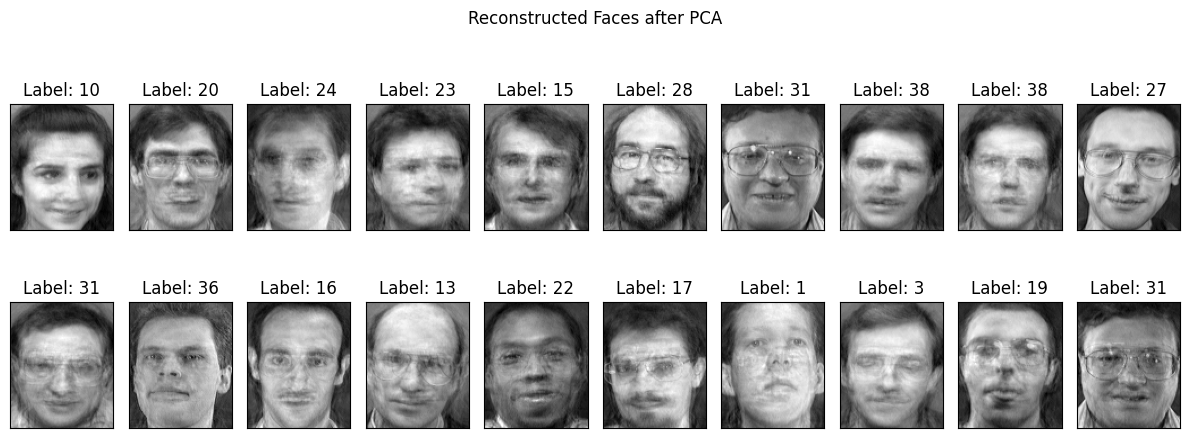

In [10]:
def visualize_reconstructed_faces(pca_obj, X_pca, y_labels, n_samples=10):
    plt.figure(figsize=(12, 5))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples//2, i+1)
        
        # 1. rebuild a main img (reverse transforme)
        reconstructed_face = np.dot(X_pca[i], pca_obj.components.T) + pca_obj.mean
        
        
        plt.imshow(reconstructed_face.reshape(112, 92), cmap='gray')  # لأن الصور الأصلية 112×92
        ax.set_title(f"Label: {y_labels[i]}")
        plt.xticks([])
        plt.yticks([])
   
    plt.suptitle('Reconstructed Faces after PCA')
    plt.tight_layout()
    plt.show()
visualize_reconstructed_faces(pca_results[0.9]['pca'], pca_results[0.9]['train'], y_train, n_samples=20)

# Autoencoder

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=10304, latent_dim=100):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Assuming images are normalized
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [12]:
# Convert the data into torch tensors
X_train_tensor = torch.FloatTensor(X_train) / 255.0  # Normalize (important!)
X_test_tensor = torch.FloatTensor(X_test) / 255.0

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



## train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder(input_dim=10304, latent_dim=100).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 50
autoencoder.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        
        optimizer.zero_grad()
        outputs, _ = autoencoder(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.6f}")

Epoch 1/50, Loss: 0.033674
Epoch 2/50, Loss: 0.025022
Epoch 3/50, Loss: 0.024079
Epoch 4/50, Loss: 0.023449
Epoch 5/50, Loss: 0.022423
Epoch 6/50, Loss: 0.020458
Epoch 7/50, Loss: 0.019525
Epoch 8/50, Loss: 0.019673
Epoch 9/50, Loss: 0.018813
Epoch 10/50, Loss: 0.019022
Epoch 11/50, Loss: 0.018377
Epoch 12/50, Loss: 0.017699
Epoch 13/50, Loss: 0.017224
Epoch 14/50, Loss: 0.016207
Epoch 15/50, Loss: 0.015639
Epoch 16/50, Loss: 0.015375
Epoch 17/50, Loss: 0.014602
Epoch 18/50, Loss: 0.014147
Epoch 19/50, Loss: 0.013803
Epoch 20/50, Loss: 0.014124
Epoch 21/50, Loss: 0.013335
Epoch 22/50, Loss: 0.012858
Epoch 23/50, Loss: 0.012374
Epoch 24/50, Loss: 0.012093
Epoch 25/50, Loss: 0.011962
Epoch 26/50, Loss: 0.011629
Epoch 27/50, Loss: 0.012056
Epoch 28/50, Loss: 0.011286
Epoch 29/50, Loss: 0.011163
Epoch 30/50, Loss: 0.011155
Epoch 31/50, Loss: 0.010795
Epoch 32/50, Loss: 0.010749
Epoch 33/50, Loss: 0.010503
Epoch 34/50, Loss: 0.010279
Epoch 35/50, Loss: 0.010130
Epoch 36/50, Loss: 0.009869
E

In [13]:
autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor.to(device))
    _, X_test_latent = autoencoder(X_test_tensor.to(device))

# Move to CPU and convert to numpy
X_train_latent = X_train_latent.cpu().numpy()
X_test_latent = X_test_latent.cpu().numpy()

In [14]:
def visualize_reconstruction(autoencoder, X_tensor, n_samples=5):
    autoencoder.eval()
    with torch.no_grad():
        reconstructed, _ = autoencoder(X_tensor[:n_samples].to(device))
        reconstructed = reconstructed.cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    for i in range(n_samples):
        # Original
        ax = plt.subplot(2, n_samples, i+1)
        plt.imshow(X_tensor[i].cpu().numpy().reshape(112,92), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed
        ax = plt.subplot(2, n_samples, n_samples+i+1)
        plt.imshow(reconstructed[i].reshape(112,92), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

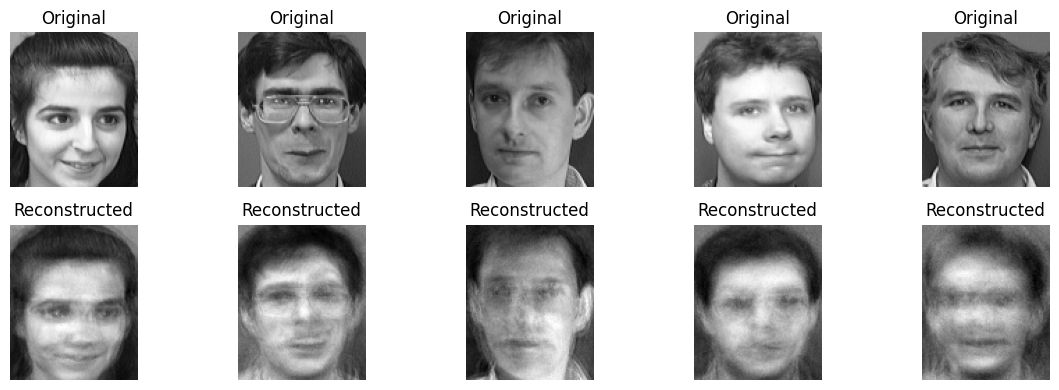

In [15]:
# Example usage
visualize_reconstruction(autoencoder, X_train_tensor, n_samples=5)

In [19]:
def visualize_reconstructions(autoencoder, X_tensor, y_labels, n_samples=10):
    autoencoder.eval()
    with torch.no_grad():
        reconstructed, _ = autoencoder(X_tensor[:n_samples].to(device))
        reconstructed = reconstructed.cpu().numpy()
    
    plt.figure(figsize=(12, 5))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples//2, i+1)
        plt.imshow(reconstructed[i].reshape(112, 92), cmap='gray')
        ax.set_title(f"Label: {y_labels[i]}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle('Reconstructed faces using Autoencoder')
    plt.tight_layout()
    plt.show()

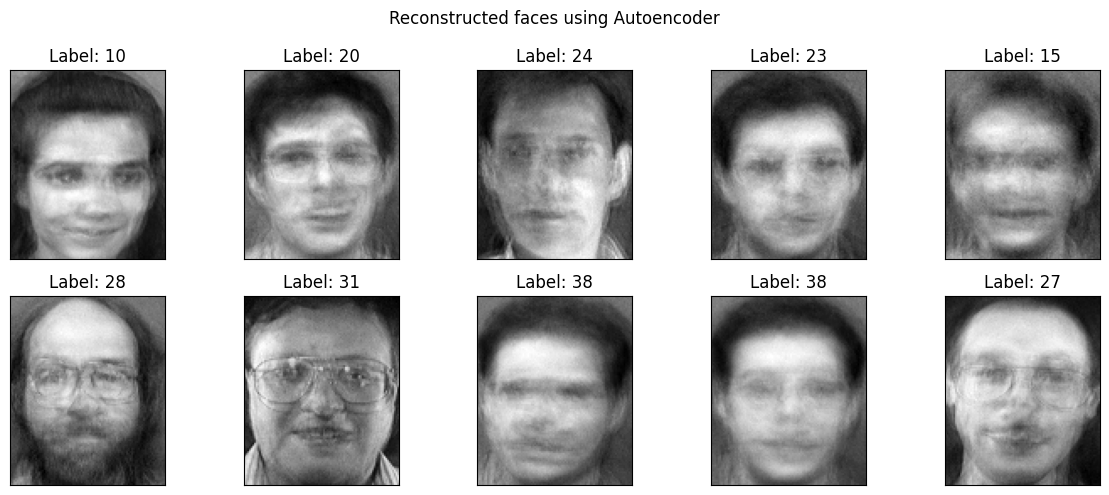

In [18]:
# Example: visualize
visualize_reconstructions(autoencoder, X_train_tensor, y_train, n_samples=10)

# K-means

In [20]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=1000, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X, y=None):
        self.y_true = y  # Store true labels if provided

        # Initialize centroids: try to pick samples with diverse labels
        if y is not None:
            unique_labels = np.unique(y)
            chosen_indices = []

            for label in unique_labels:
                label_indices = np.where(y == label)[0]
                if len(label_indices) > 0:
                    chosen_indices.append(np.random.choice(label_indices))
                if len(chosen_indices) == self.n_clusters:
                    break

            # If not enough labels, fill the rest randomly
            while len(chosen_indices) < self.n_clusters:
                idx = np.random.choice(X.shape[0])
                if idx not in chosen_indices:
                    chosen_indices.append(idx)

            self.centroids = X[chosen_indices]
        else:
            self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        # KMeans iterations
        for _ in range(self.max_iters):
            self.labels = self._assign_cluster_labels(X, y)
            new_centroids = self._calculate_centroids(X)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids


    def _assign_labels(self, X):
        # Compute distance from each point to each centroid
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # Assign labels based on closest centroid
        return np.argmin(distances, axis=1)

    def _assign_cluster_labels(self, X, y=None):
        # Compute distances and assign to nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        cluster_indices = np.argmin(distances, axis=1)

        if y is None:
            # Predict using stored majority labels
            return np.array([self.cluster_to_label.get(c, -1) for c in cluster_indices])
        else:
            # Assign majority label from y for each cluster
            self.cluster_to_label = {}
            labels = np.zeros_like(cluster_indices)

            for cluster in range(self.n_clusters):
                indices = np.where(cluster_indices == cluster)[0]
                if len(indices) > 0:
                    majority_label = Counter(y[indices]).most_common(1)[0][0]
                else:
                    majority_label = -1  # fallback label for empty cluster
                self.cluster_to_label[cluster] = majority_label
                labels[indices] = majority_label

            return labels

    def _calculate_centroids(self, X):
        # Calculate the mean of the points assigned to each centroid
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            points = X[self.labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)
        return centroids

    def predict(self, X):
        return self._assign_cluster_labels(X)

## Training using PCA

In [21]:
# First, train PCA for each alpha for the training and test data
alphas = [0.8, 0.85, 0.9, 0.95]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store PCA-transformed datasets {alpha: pca data}
pca_transformed_trained_data = {}
pca_transformed_tested_data = {}

for alpha in alphas:
    pca = PCA(alpha=alpha)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    pca_transformed_trained_data[alpha] = X_train_pca
    pca_transformed_tested_data[alpha] = X_test_pca
    print(f"PCA at alpha={alpha}")
    print(f"Shape of the PCA trained data ={X_train_pca.shape}")
    print(f"Shape of the PCA tested data ={X_test_pca.shape}")
    print("="*100)

PCA at alpha=0.8
Shape of the PCA trained data =(200, 35)
Shape of the PCA tested data =(200, 35)
PCA at alpha=0.85
Shape of the PCA trained data =(200, 51)
Shape of the PCA tested data =(200, 51)
PCA at alpha=0.9
Shape of the PCA trained data =(200, 75)
Shape of the PCA tested data =(200, 75)
PCA at alpha=0.95
Shape of the PCA trained data =(200, 114)
Shape of the PCA tested data =(200, 114)


In [22]:
# Then, for each transformed dataset, train KMeans
clusters = [20, 40, 60]

# Structure: {alpha: {k: model}}
kmeans_models = defaultdict(dict)

for alpha, X_train_pca in pca_transformed_trained_data.items():
    for k in clusters:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train_pca, y_train)
        kmeans_models[alpha][k] = kmeans

model = kmeans_models[0.8][40]
print(f"At alpha=0.8 and k=40 cluster labels:\n{model.labels}")

At alpha=0.8 and k=40 cluster labels:
[10 20 24  3 15 37 34 38 38 27 31 36 16 25 22 36 18 12 19 34  9  4 30 37
 34 11 19 31 15 21 39 20  1 13  3  8  2  2  4 18 13 12 14 18 23 12 25 15
  6 39  7 38 39 15 37 35  6 10 23 23 16 10 24 26 14 19  9 22 37  2 21 15
  4  1 19  7 25  2  8  7 32 18 27 22 34 33  4 14 34 11 18  6  8 24 26 34
 23 39 25  9 32 24  6 30 13  6 26 11  7 30 16 32 12  3 35  9 11 13  4 25
 18 25  9 23 25 18 36 30 15 14 16 27 37 25 18  2 32 25 33 21 36 36 22 27
 19 24 39  7 37 19 36 36 21 39 26  1 23 21 15 35 36 21 16 36 11 33  1 33
 12  1 27 33 18  1  4 34 15 14 23 34 32 21 30 21  3  8 10 15 15 35  9 12
 13 22 13  1 26 37 36  8]


## Validation using PCA

In [23]:
predictions = defaultdict(dict)

for alpha, models_by_k in kmeans_models.items():
    # Get the PCA-transformed test data
    X_train_pca = pca_transformed_trained_data[alpha]  

    for k, model in models_by_k.items():
        y_pred = model.predict(X_train_pca)
        predictions[alpha][k] = y_pred

## Evaluation on validation data using PCA

Alpha: 0.8, k: 20:
Accuracy: 0.12
F1-Score: 0.06


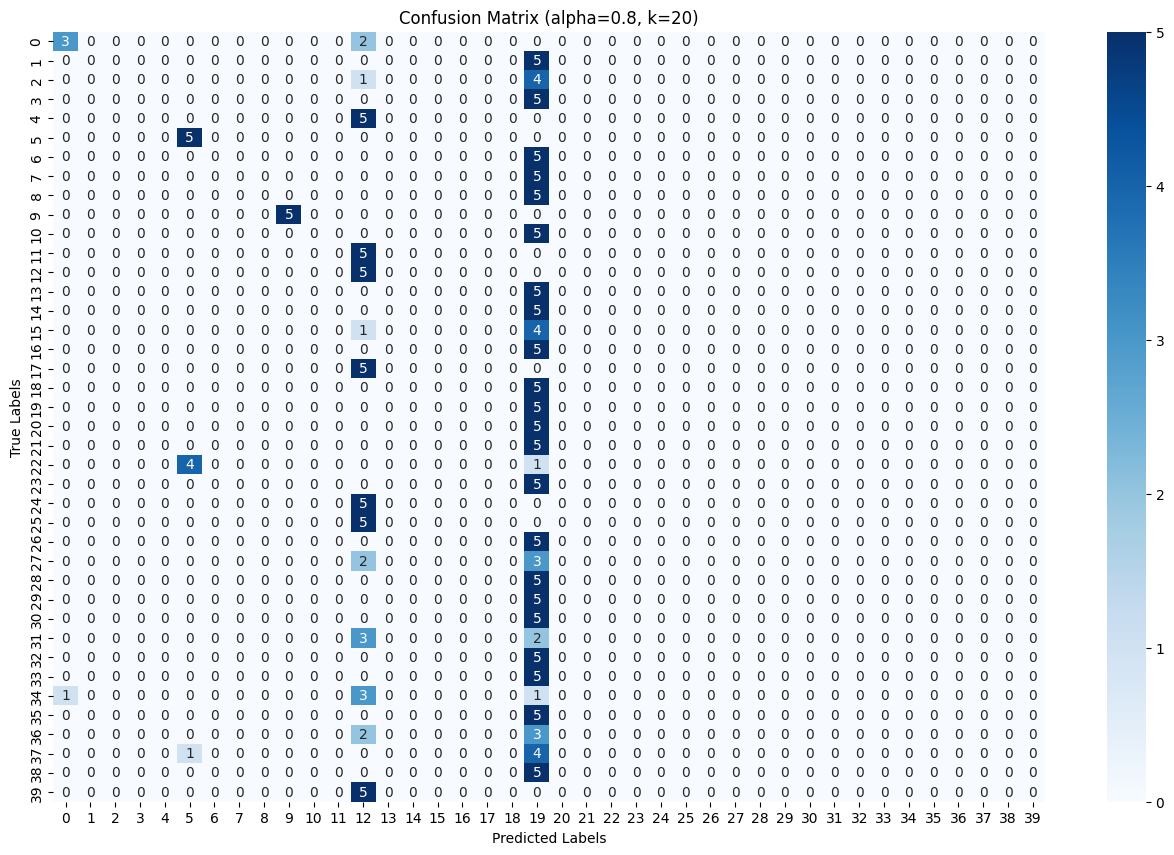

Alpha: 0.8, k: 40:
Accuracy: 0.76
F1-Score: 0.72


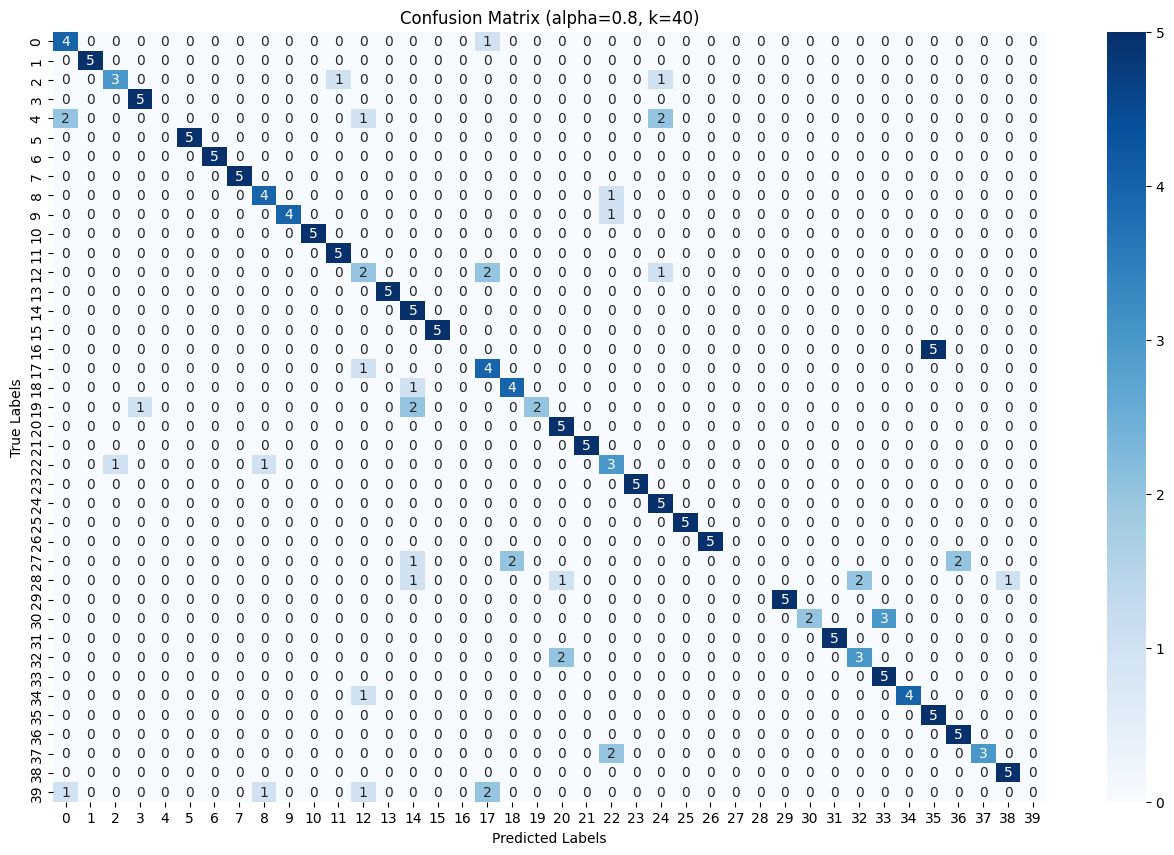

Alpha: 0.8, k: 60:
Accuracy: 0.81
F1-Score: 0.80


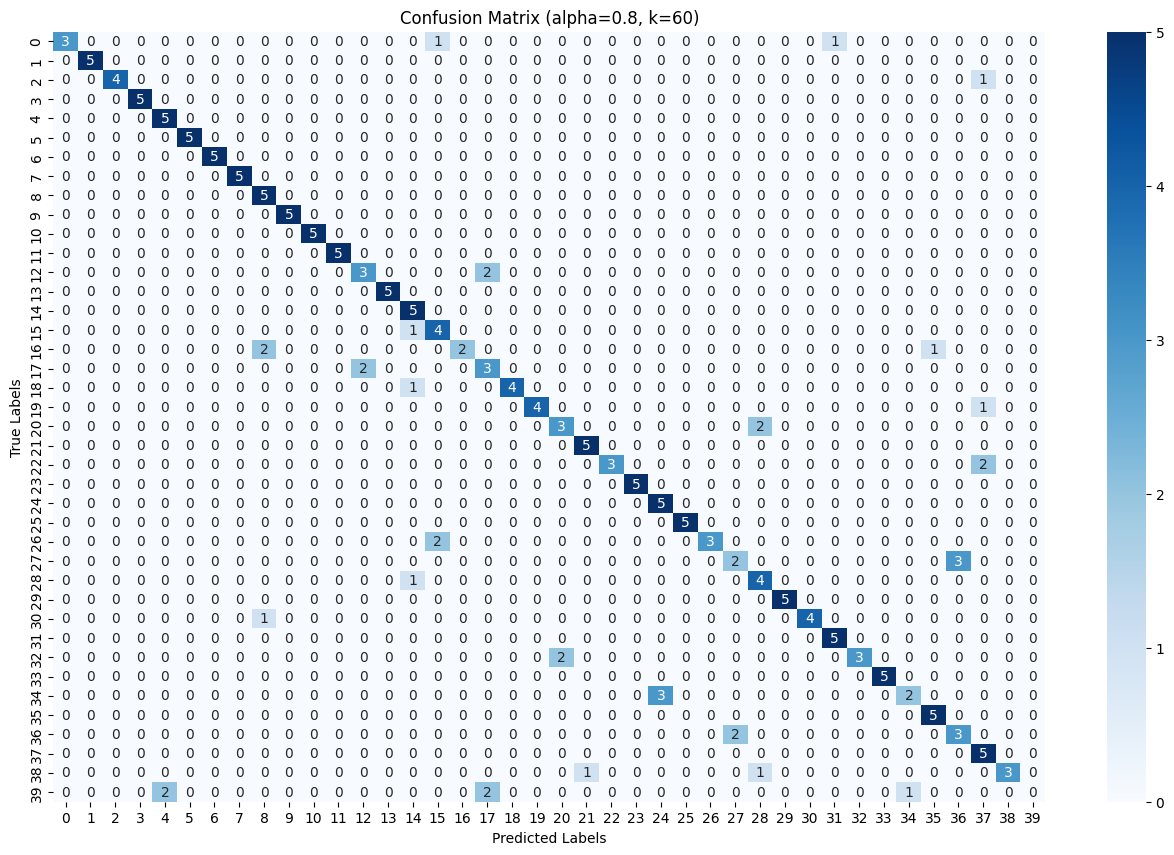

Alpha: 0.85, k: 20:
Accuracy: 0.14
F1-Score: 0.11


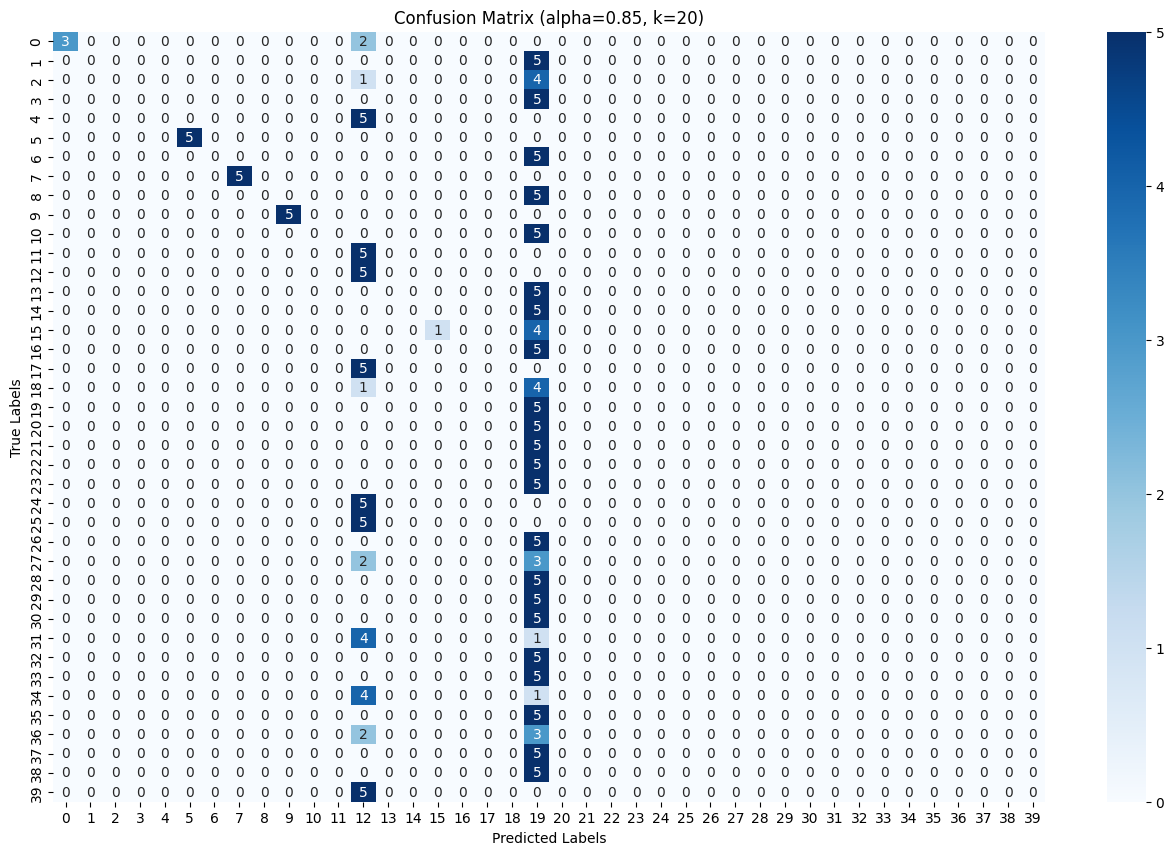

Alpha: 0.85, k: 40:
Accuracy: 0.74
F1-Score: 0.72


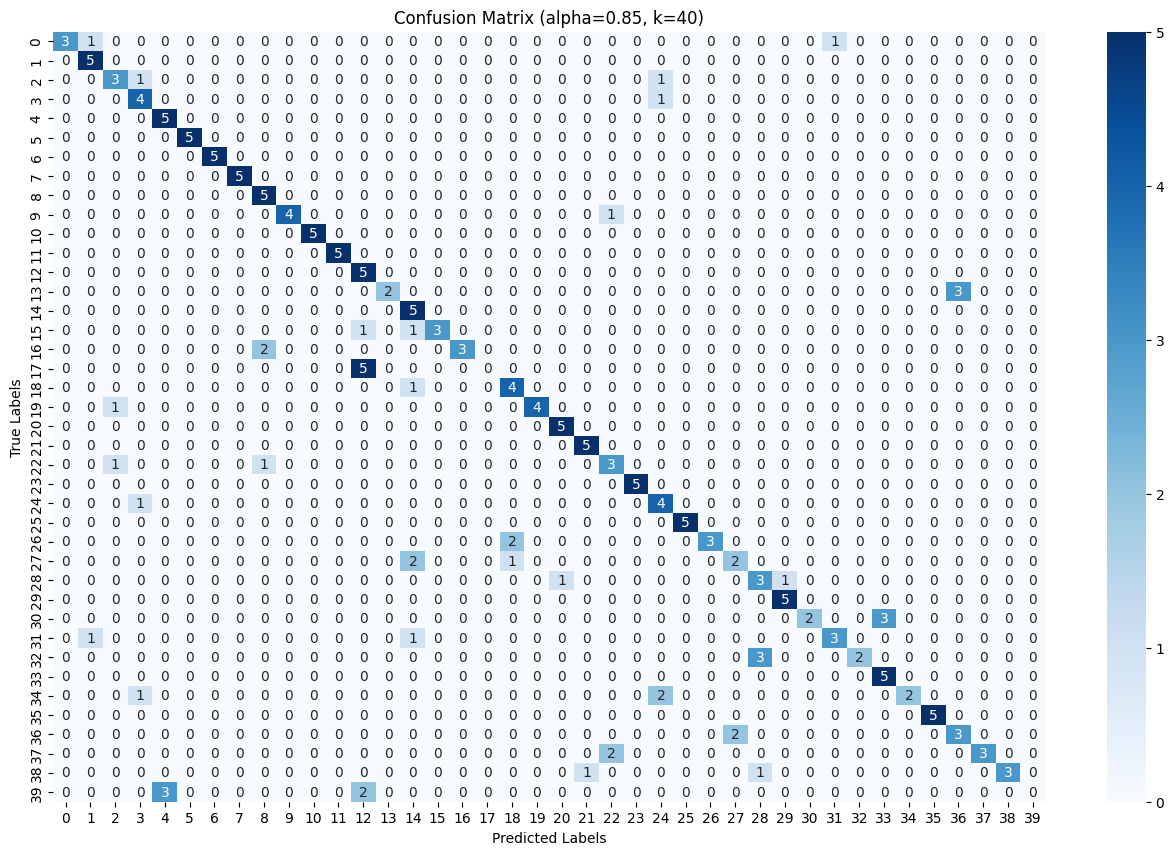

Alpha: 0.85, k: 60:
Accuracy: 0.84
F1-Score: 0.83


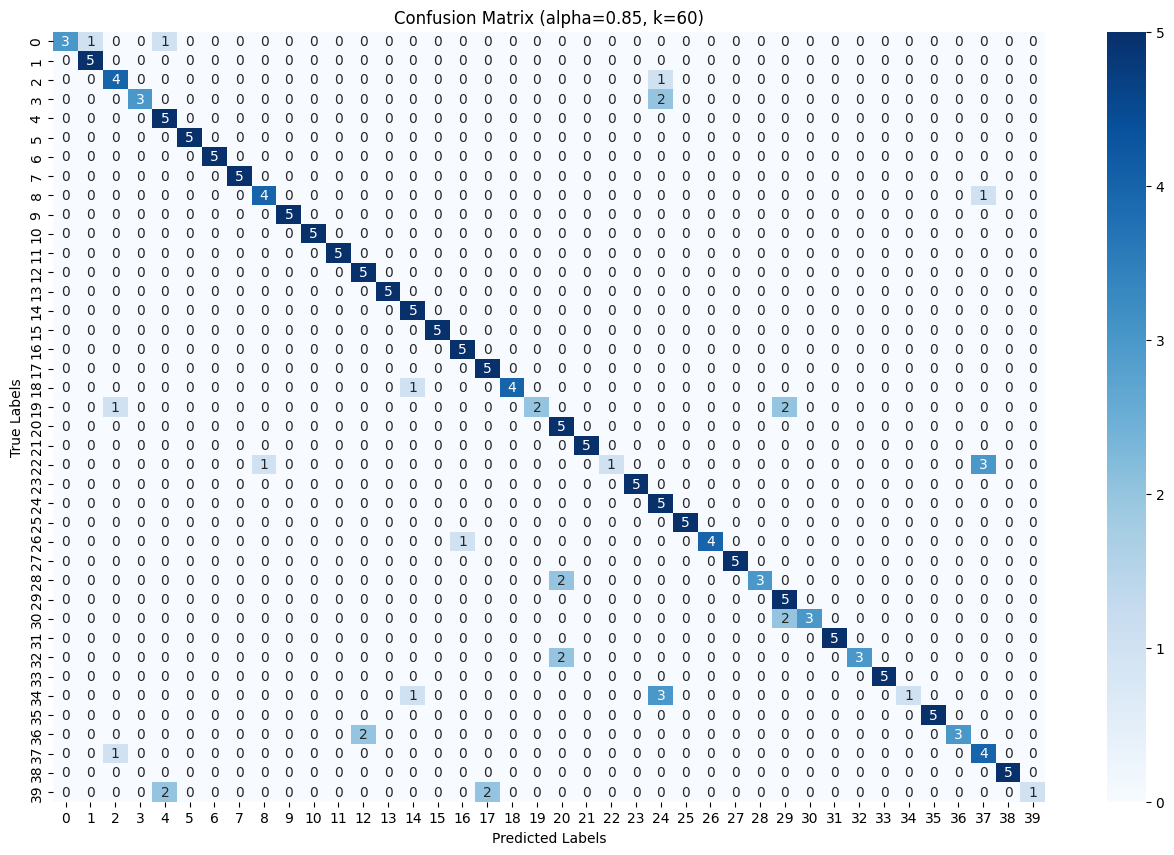

Alpha: 0.9, k: 20:
Accuracy: 0.17
F1-Score: 0.11


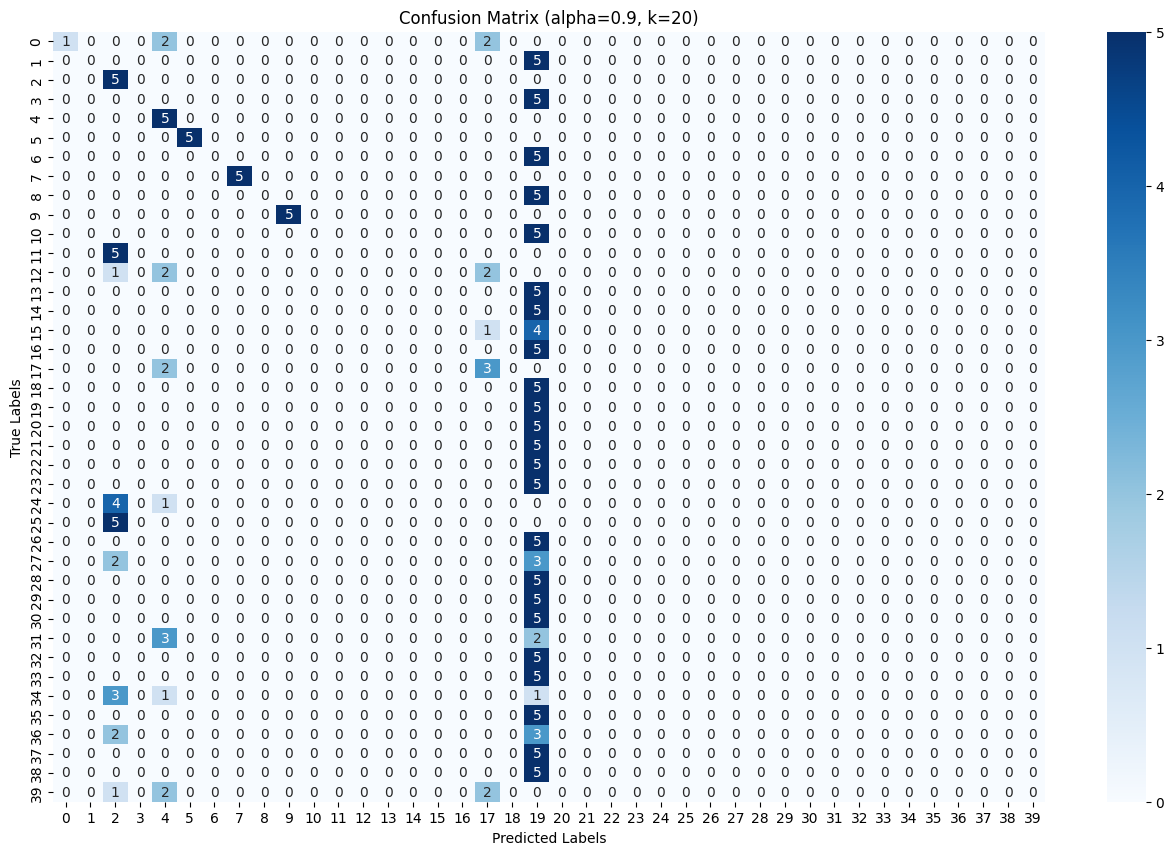

Alpha: 0.9, k: 40:
Accuracy: 0.76
F1-Score: 0.75


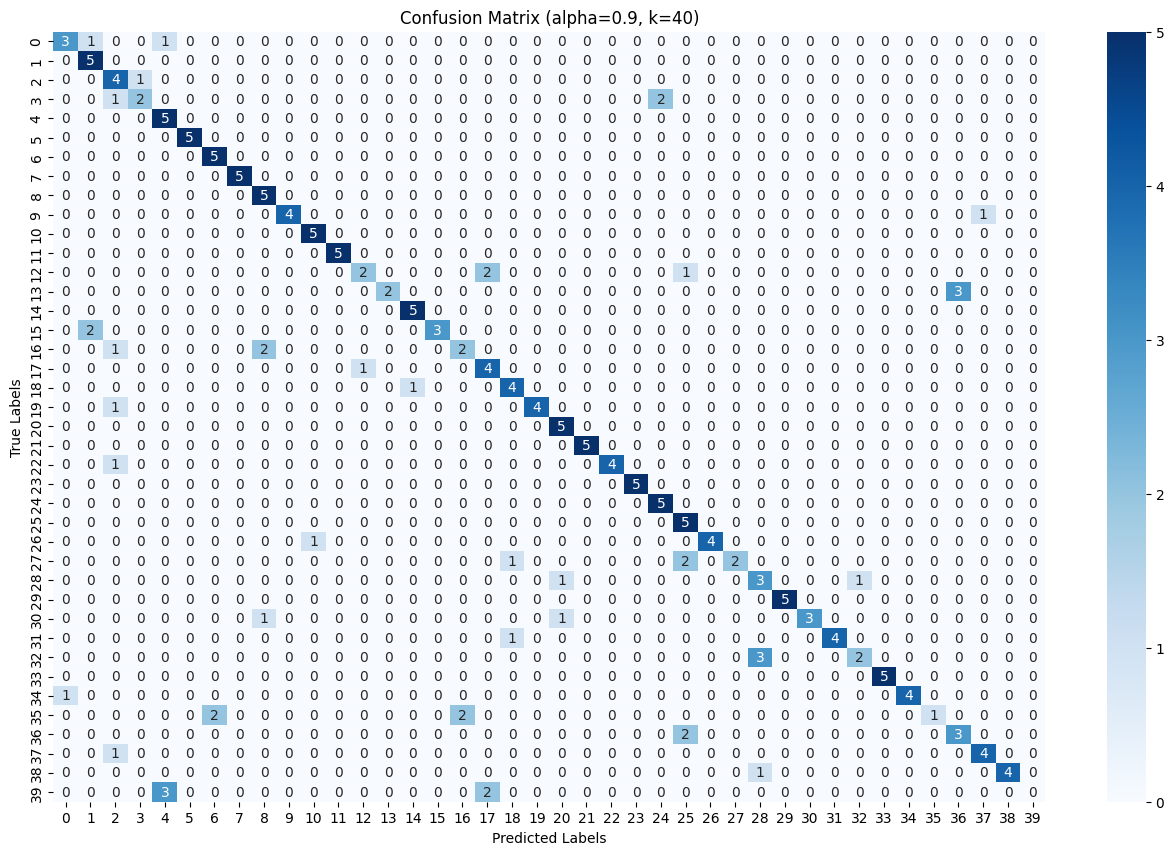

Alpha: 0.9, k: 60:
Accuracy: 0.84
F1-Score: 0.83


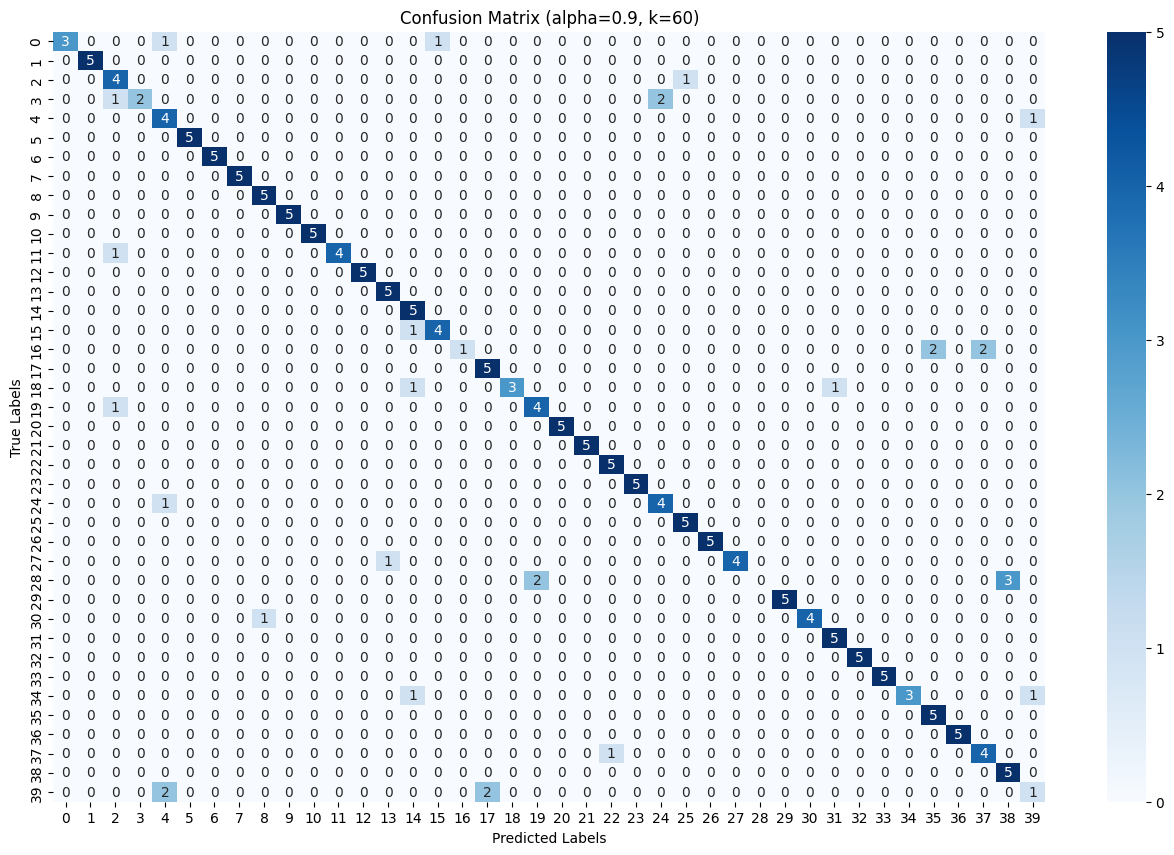

Alpha: 0.95, k: 20:
Accuracy: 0.14
F1-Score: 0.10


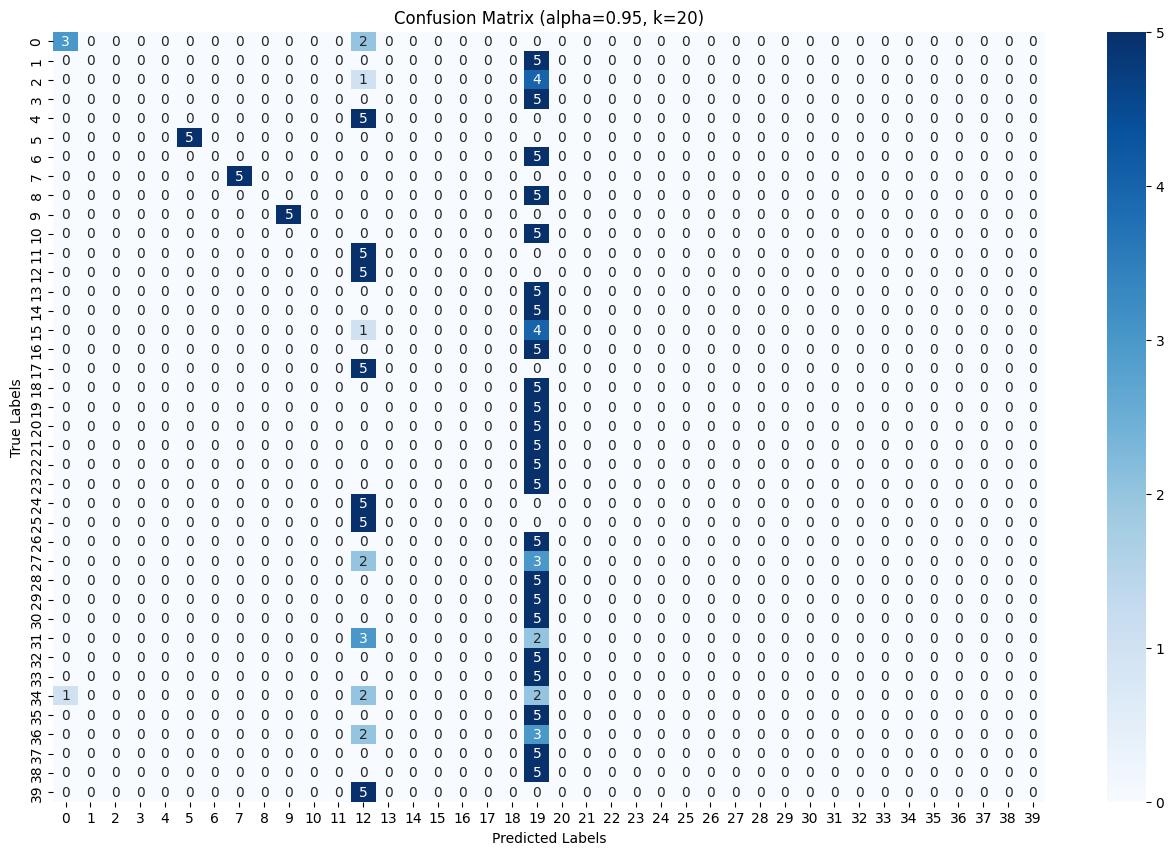

Alpha: 0.95, k: 40:
Accuracy: 0.72
F1-Score: 0.69


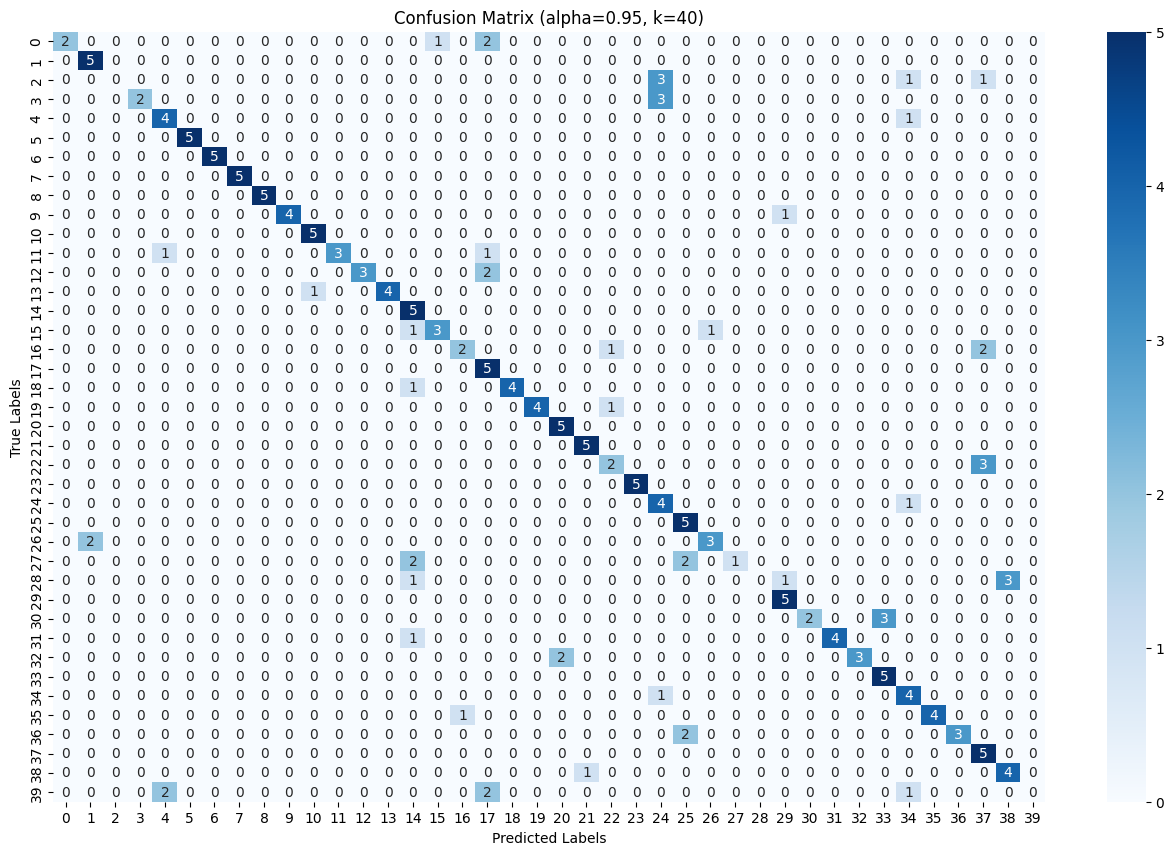

Alpha: 0.95, k: 60:
Accuracy: 0.82
F1-Score: 0.80


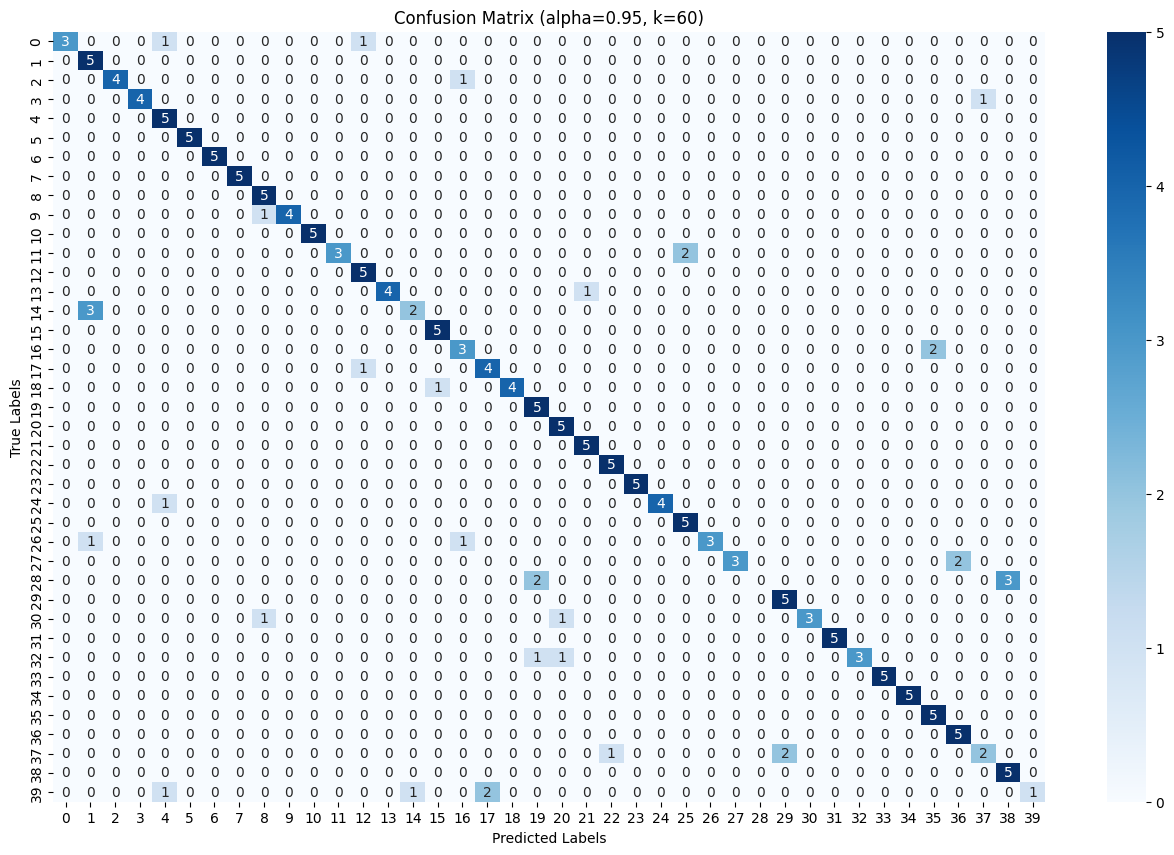

In [24]:
accuracy_results = defaultdict(dict)

for alpha, preds_by_k in predictions.items():
    for k, y_pred in preds_by_k.items():
        acc = accuracy_score(y_train, y_pred)
        accuracy_results[alpha][k] = acc
        
        f1 = f1_score(y_train, y_pred, average='macro')  # 'macro' for multiclass
        
        cm = confusion_matrix(y_train, y_pred)

        print(f"Alpha: {alpha}, k: {k}:")
    
        # Accuracy
        print(f"Accuracy: {acc:.2f}")
        
        # F1-score
        print(f"F1-Score: {f1:.2f}")
        
        # Confusion Matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix (alpha={alpha}, k={k})")
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


In [25]:
# Flatten the dictionary into a list of results
results = []
for alpha, preds_by_k in accuracy_results.items():
    for k, acc in preds_by_k.items():
        results.append({'alpha': alpha, 'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    alpha   k  accuracy
0    0.80  20     0.115
1    0.80  40     0.760
2    0.80  60     0.810
3    0.85  20     0.145
4    0.85  40     0.740
5    0.85  60     0.840
6    0.90  20     0.170
7    0.90  40     0.760
8    0.90  60     0.845
9    0.95  20     0.140
10   0.95  40     0.720
11   0.95  60     0.820


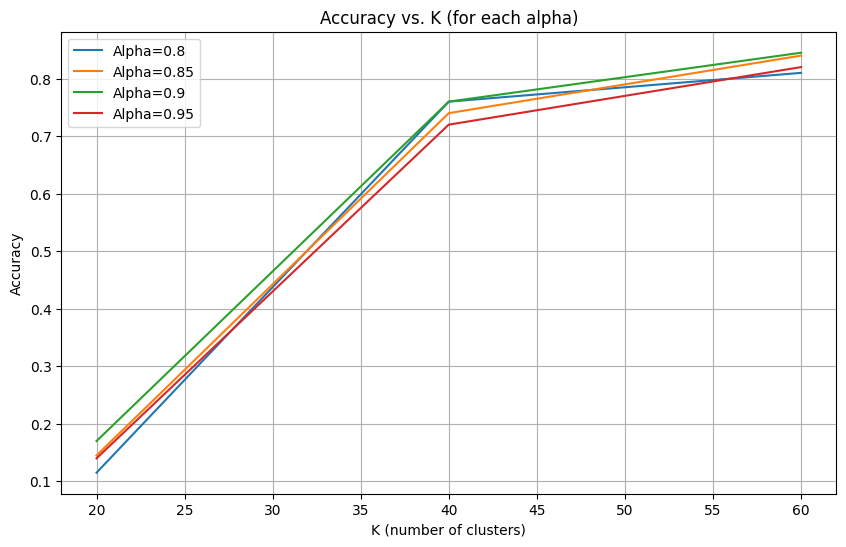

In [26]:
# Plot accuracy for different K values for each alpha
plt.figure(figsize=(10, 6))

for alpha in accuracy_results:
    ks = list(accuracy_results[alpha].keys())
    accuracies = list(accuracy_results[alpha].values())
    plt.plot(ks, accuracies, label=f'Alpha={alpha}')

plt.xlabel('K (number of clusters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K (for each alpha)')
plt.legend()
plt.grid(True)
plt.show()

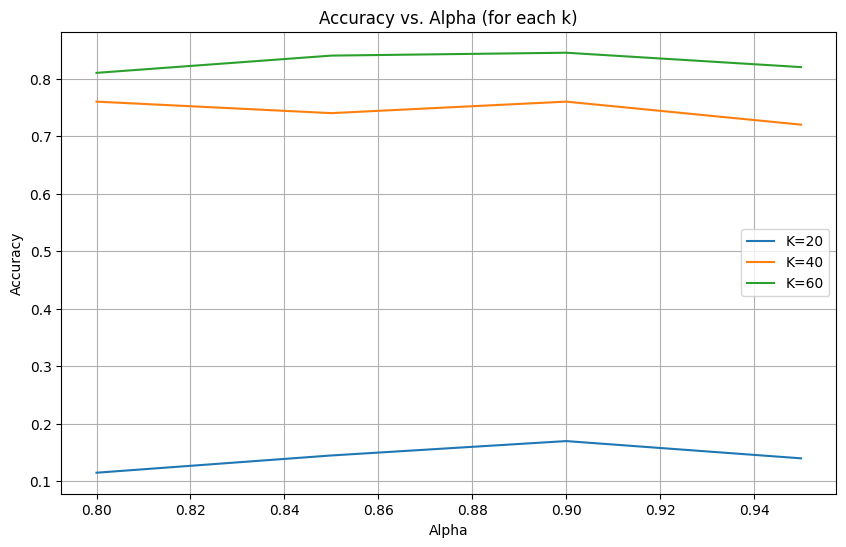

In [27]:
# Plot accuracy for different alpha values for each k
plt.figure(figsize=(10, 6))

for k in accuracy_results[next(iter(accuracy_results))]:  # Assuming k exists for all alphas
    alphas = list(accuracy_results.keys())  # List of alpha values
    accuracies = [accuracy_results[alpha][k] for alpha in alphas]  # Accuracy for each alpha for this k
    plt.plot(alphas, accuracies, label=f'K={k}')

plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha (for each k)')
plt.legend()
plt.grid(True)
plt.show()

## Testing using PCA

In [28]:
predictions = defaultdict(dict)

for alpha, models_by_k in kmeans_models.items():
    # Get the PCA-transformed test data
    X_test_pca = pca_transformed_tested_data[alpha]  

    for k, model in models_by_k.items():
        y_pred = model.predict(X_test_pca)
        predictions[alpha][k] = y_pred

## Evaluation on testing data using PCA

Alpha: 0.8, k: 20:
Accuracy: 0.12
F1-Score: 0.06


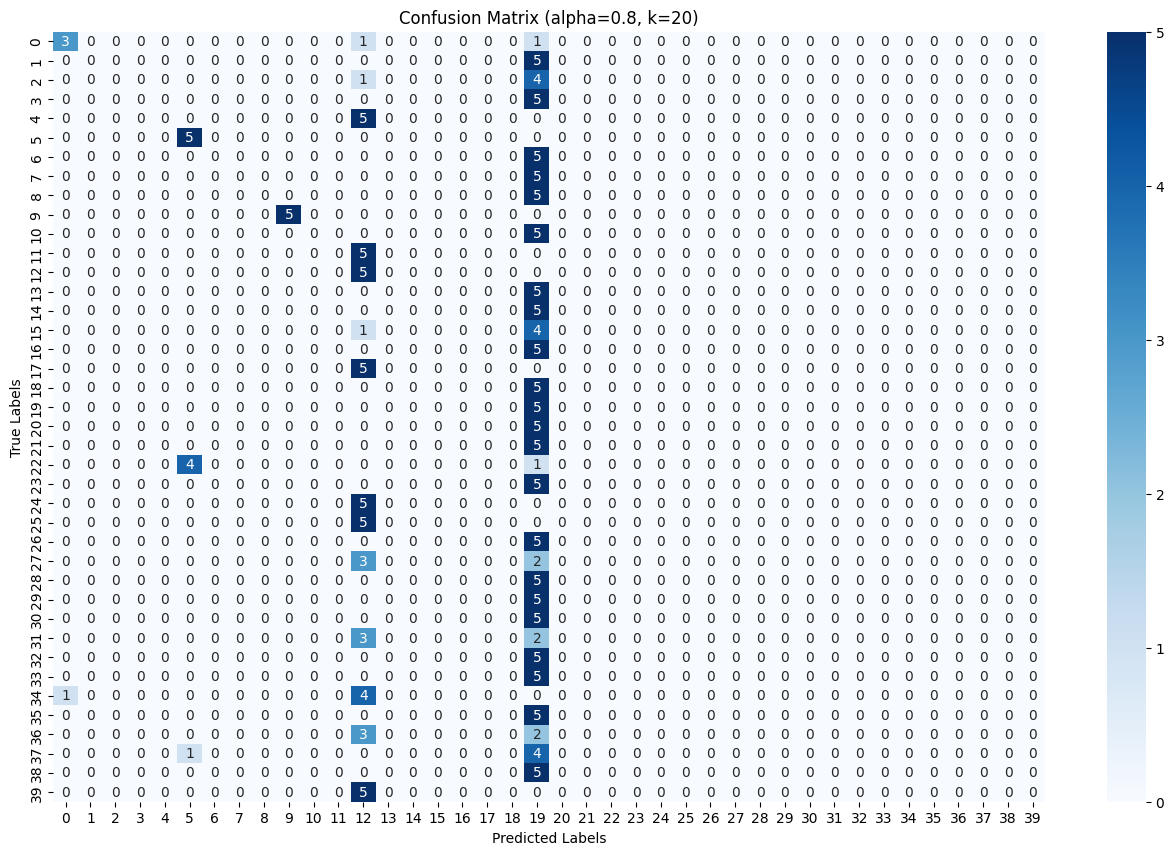

Alpha: 0.8, k: 40:
Accuracy: 0.72
F1-Score: 0.68


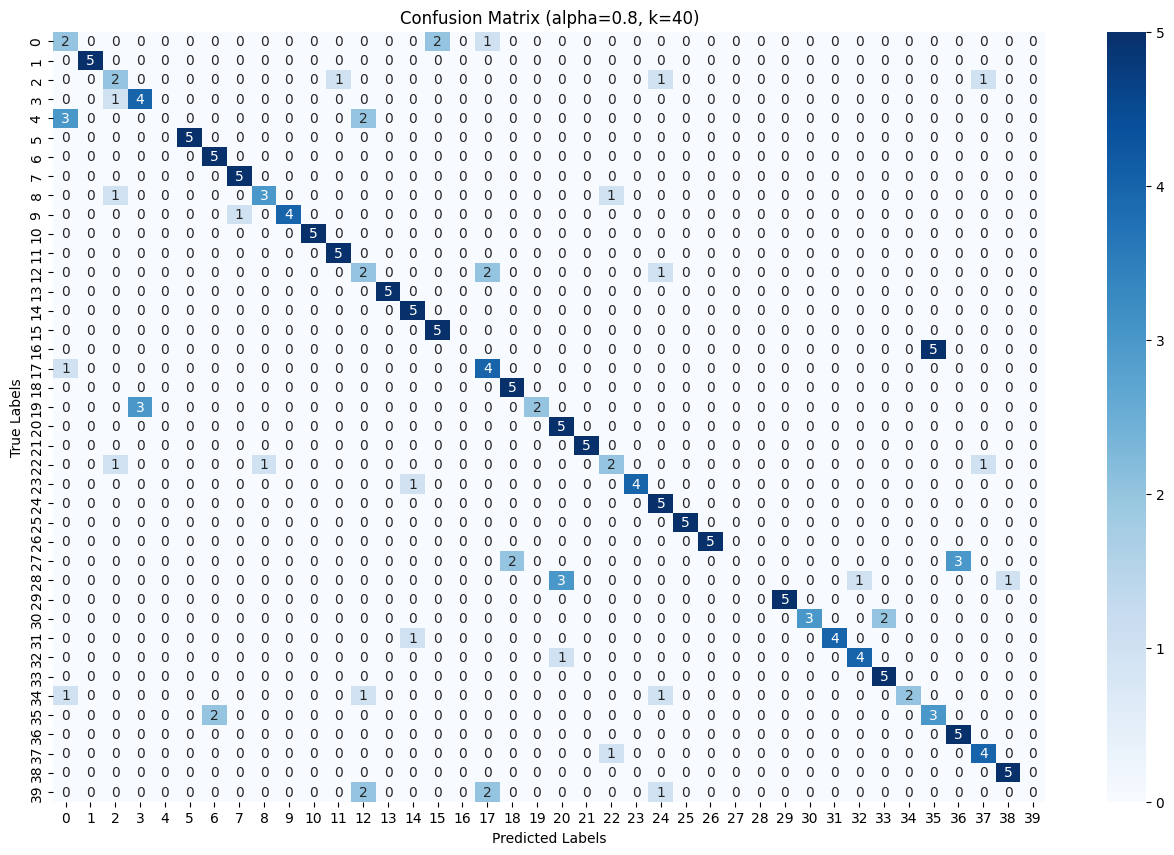

Alpha: 0.8, k: 60:
Accuracy: 0.78
F1-Score: 0.77


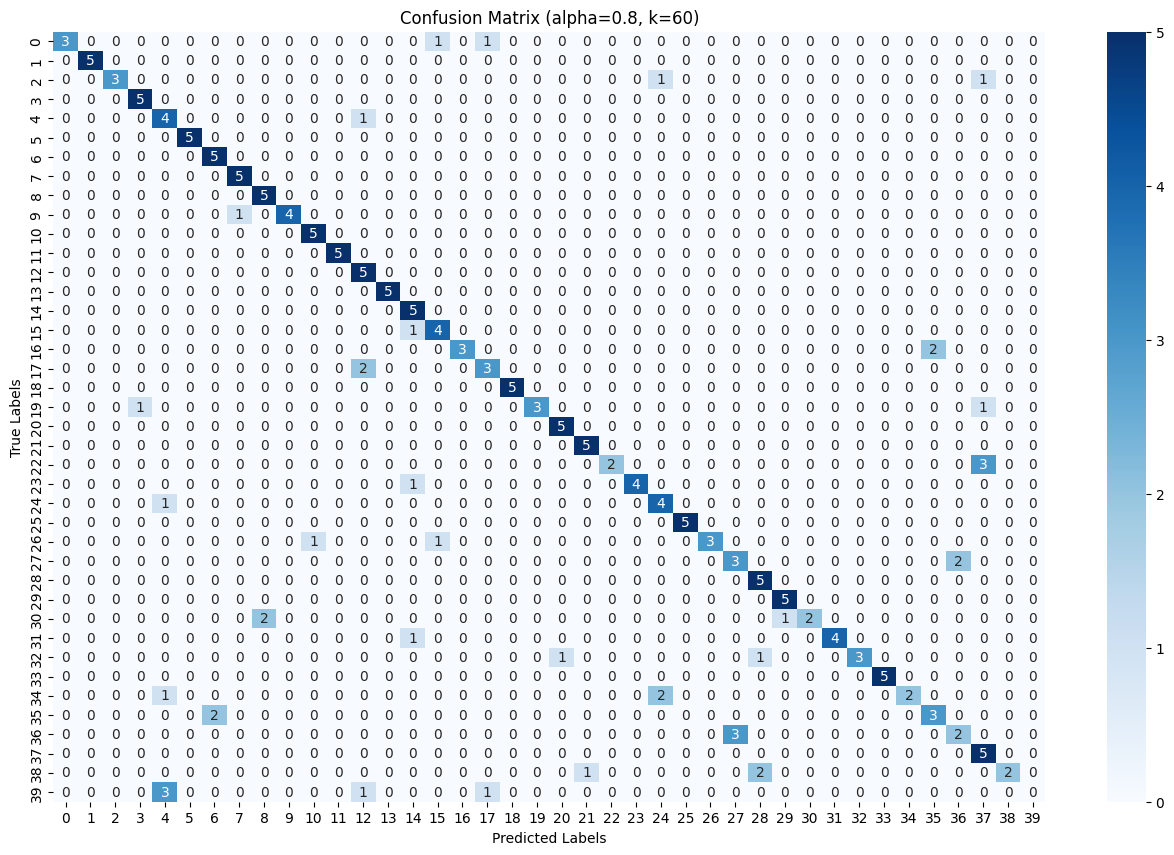

Alpha: 0.85, k: 20:
Accuracy: 0.14
F1-Score: 0.10


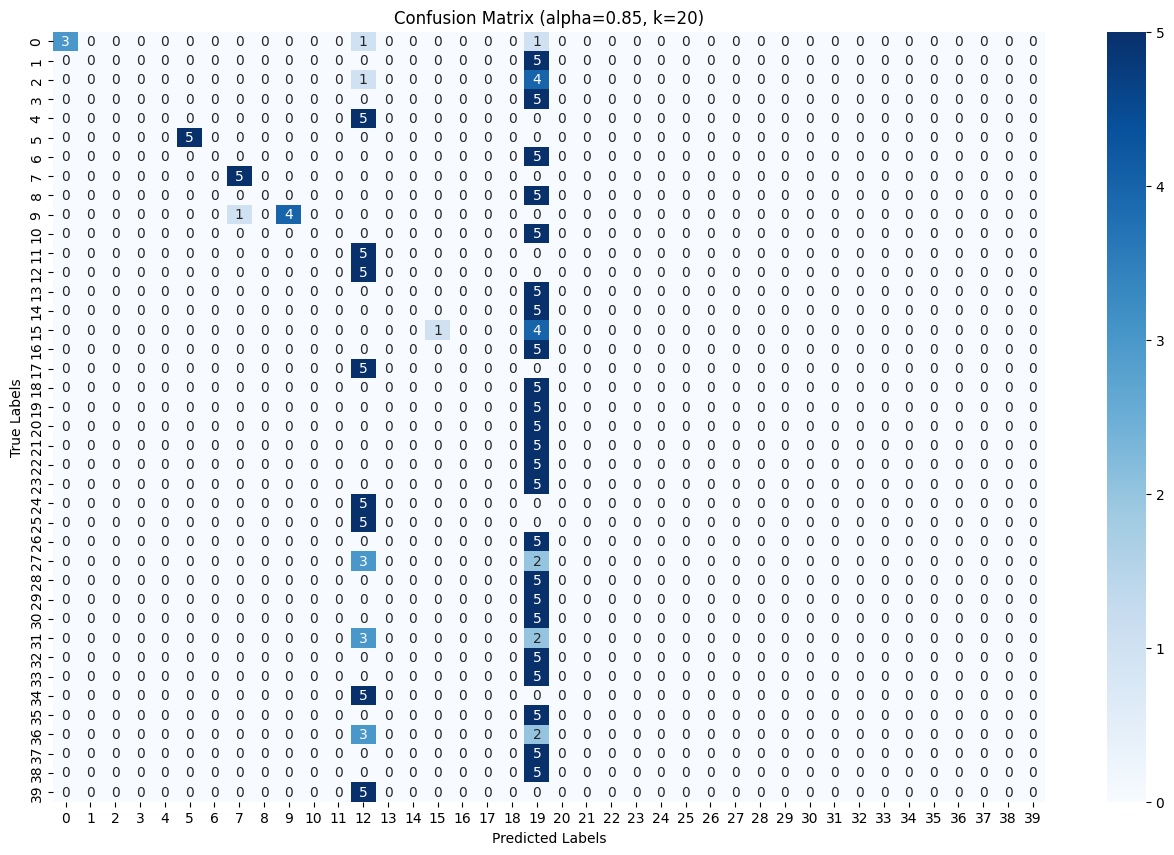

Alpha: 0.85, k: 40:
Accuracy: 0.70
F1-Score: 0.70


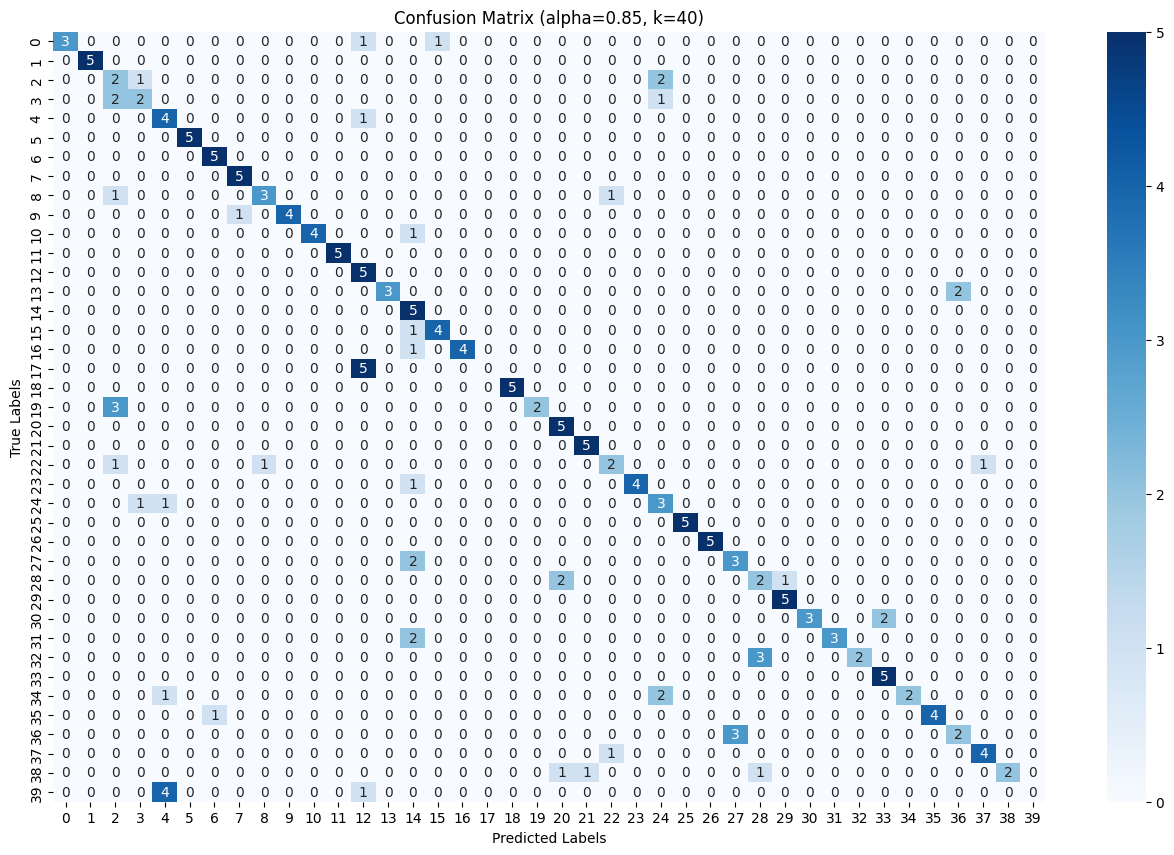

Alpha: 0.85, k: 60:
Accuracy: 0.80
F1-Score: 0.78


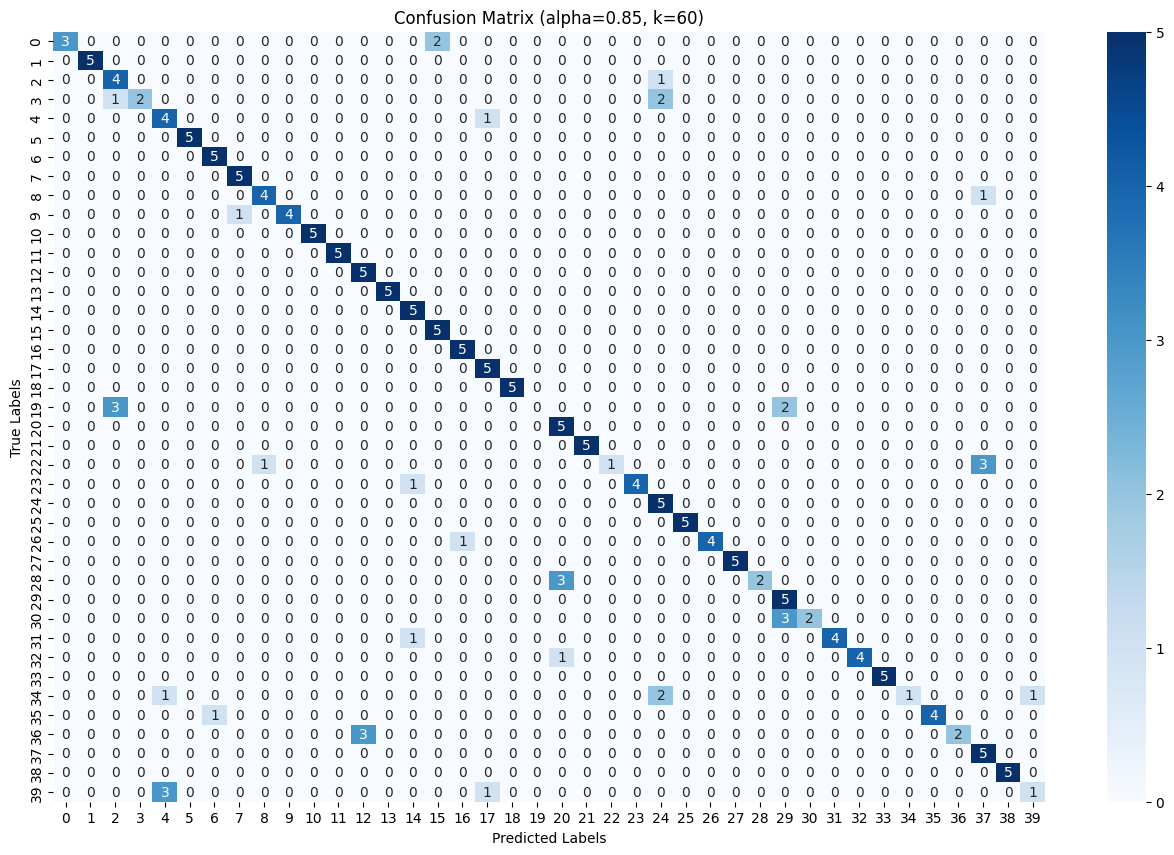

Alpha: 0.9, k: 20:
Accuracy: 0.16
F1-Score: 0.10


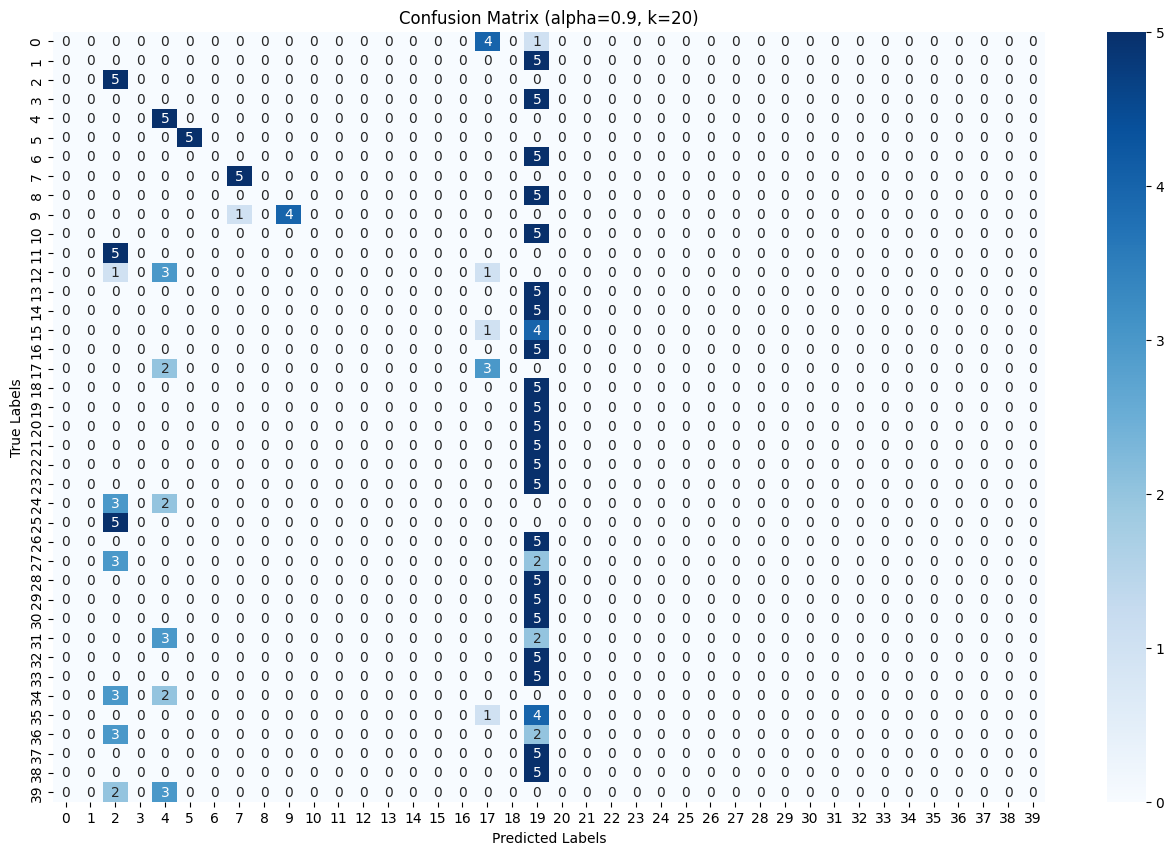

Alpha: 0.9, k: 40:
Accuracy: 0.70
F1-Score: 0.69


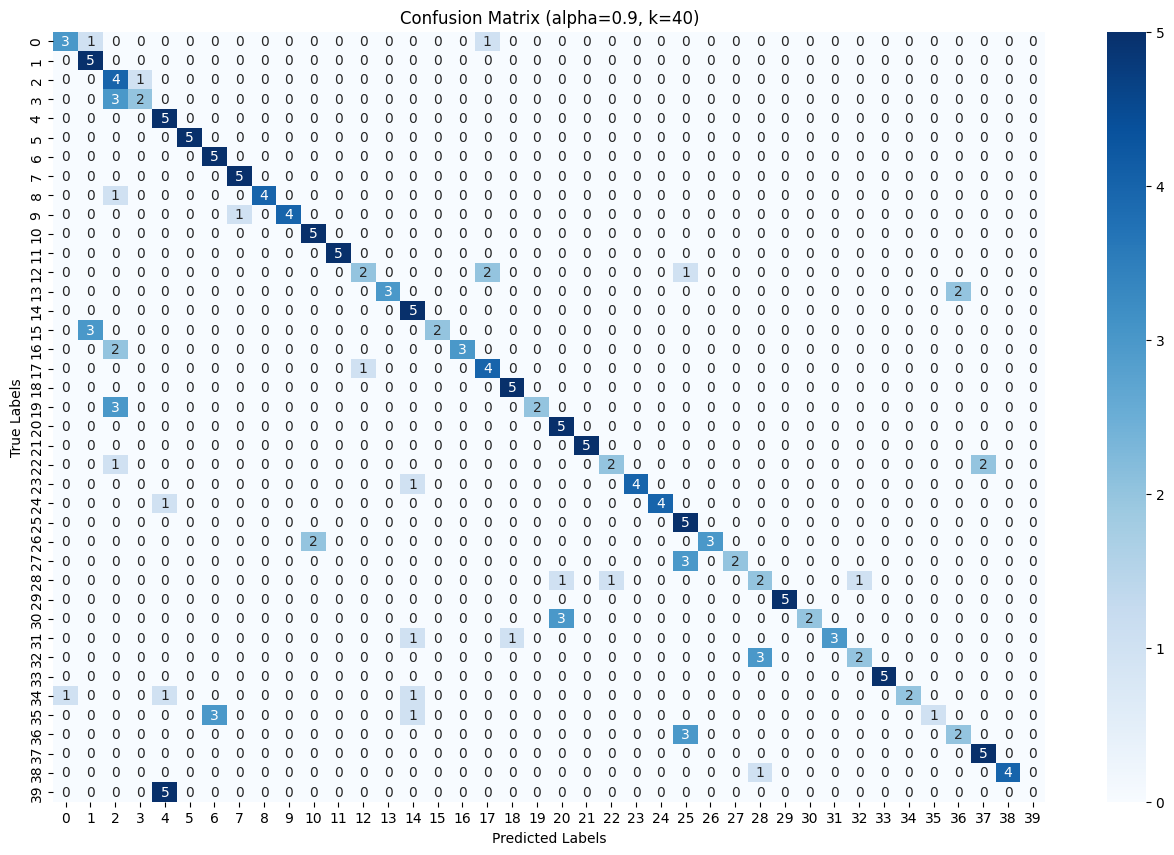

Alpha: 0.9, k: 60:
Accuracy: 0.80
F1-Score: 0.79


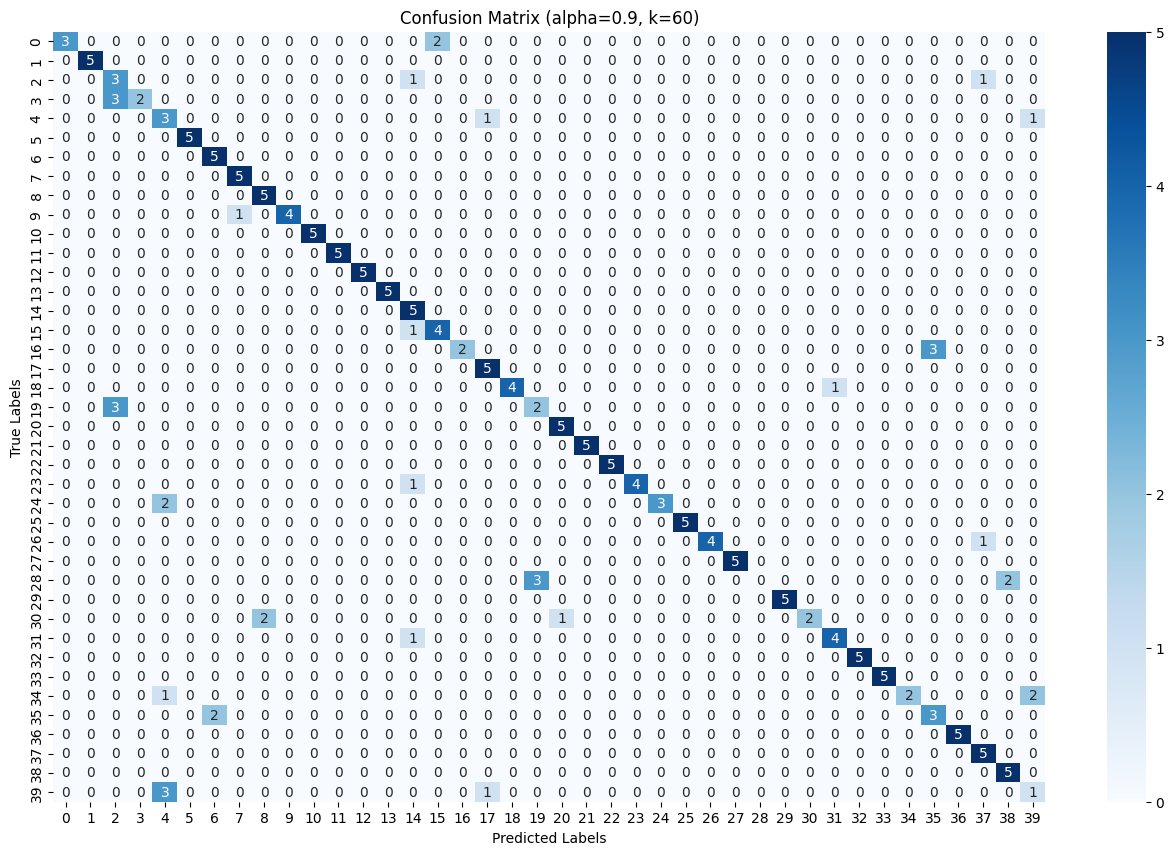

Alpha: 0.95, k: 20:
Accuracy: 0.14
F1-Score: 0.09


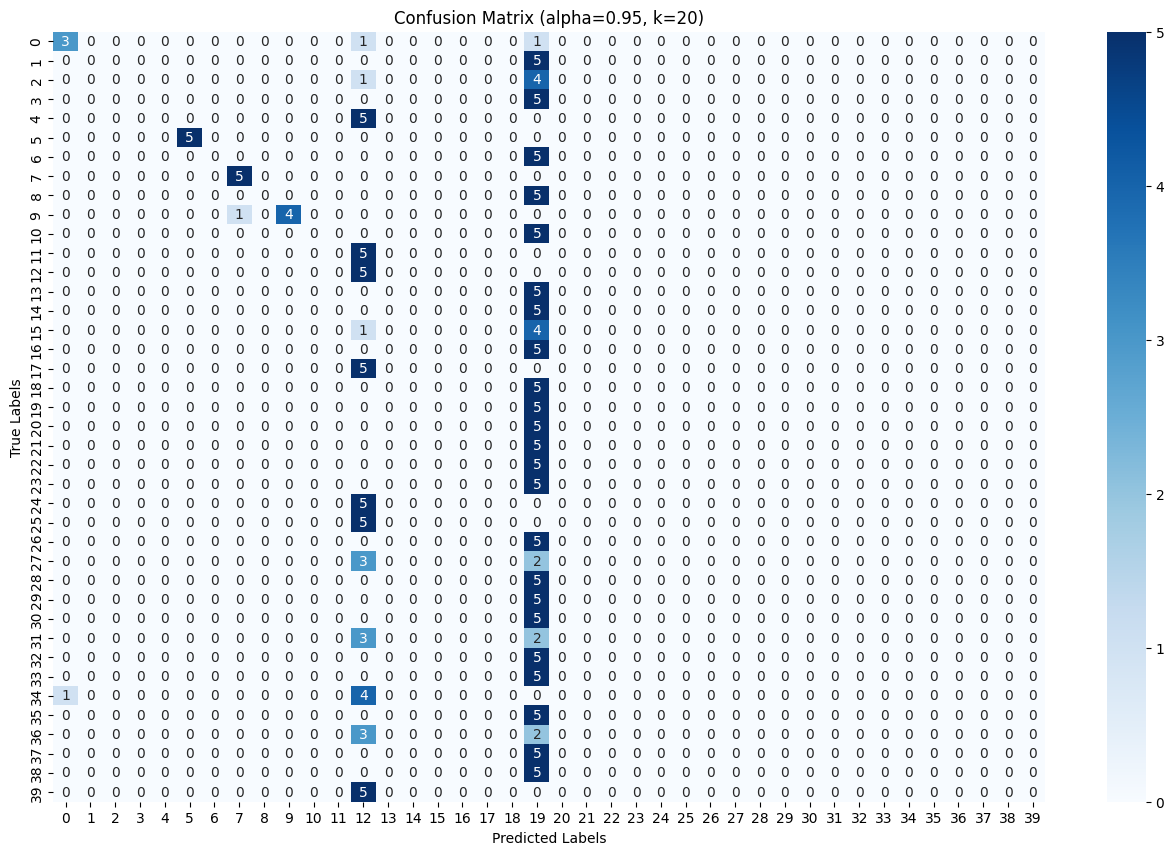

Alpha: 0.95, k: 40:
Accuracy: 0.68
F1-Score: 0.64


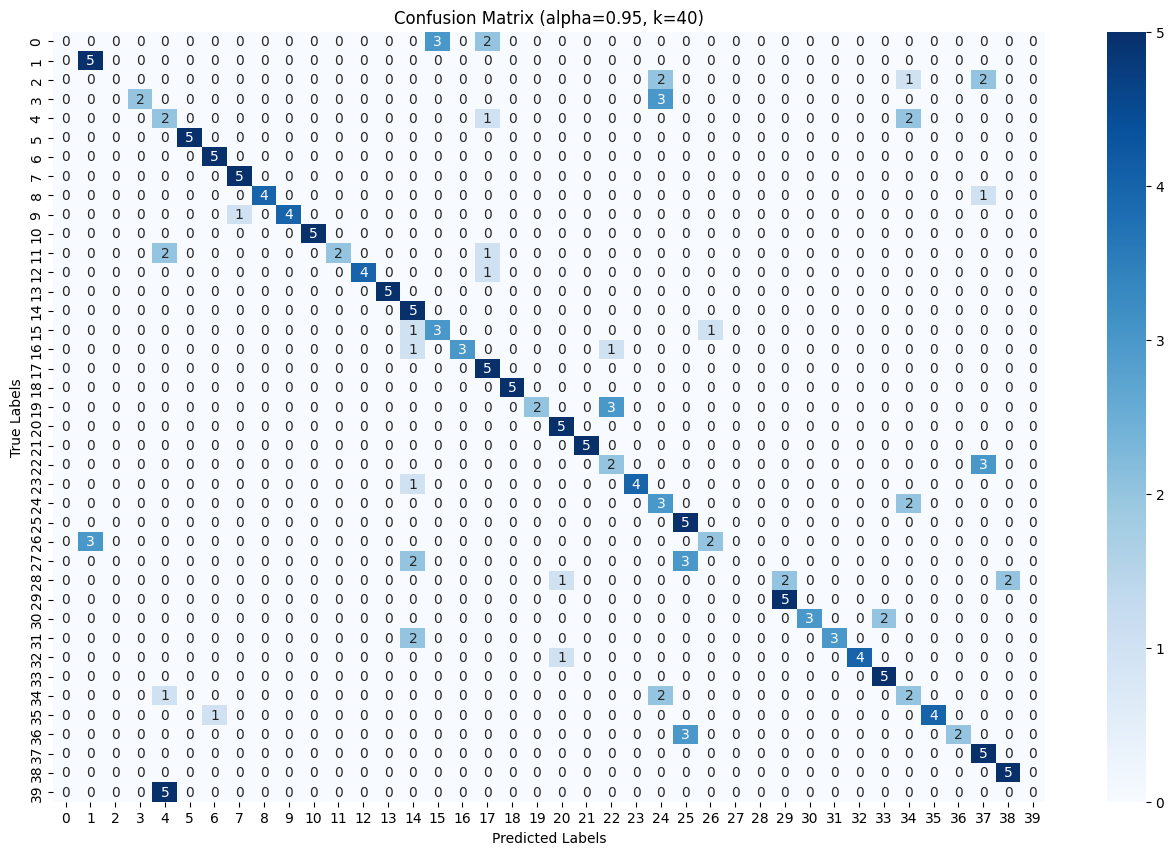

Alpha: 0.95, k: 60:
Accuracy: 0.77
F1-Score: 0.75


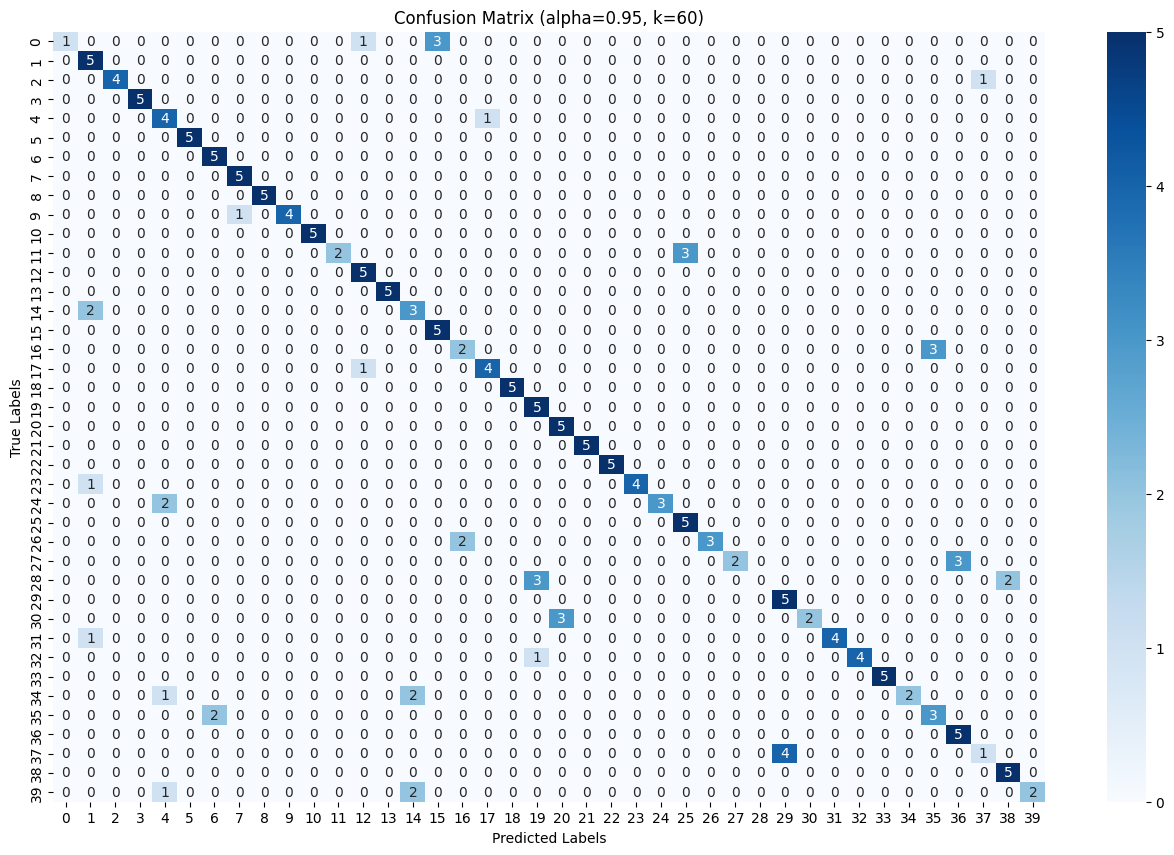

In [29]:
accuracy_results = defaultdict(dict)

for alpha, preds_by_k in predictions.items():
    for k, y_pred in preds_by_k.items():
        acc = accuracy_score(y_test, y_pred)
        accuracy_results[alpha][k] = acc
        
        f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
        
        cm = confusion_matrix(y_test, y_pred)

        print(f"Alpha: {alpha}, k: {k}:")
    
        # Accuracy
        print(f"Accuracy: {acc:.2f}")
        
        # F1-score
        print(f"F1-Score: {f1:.2f}")
        
        # Confusion Matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix (alpha={alpha}, k={k})")
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


In [30]:
# Flatten the dictionary into a list of results
results = []
for alpha, preds_by_k in accuracy_results.items():
    for k, acc in preds_by_k.items():
        results.append({'alpha': alpha, 'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    alpha   k  accuracy
0    0.80  20     0.115
1    0.80  40     0.720
2    0.80  60     0.780
3    0.85  20     0.140
4    0.85  40     0.705
5    0.85  60     0.800
6    0.90  20     0.160
7    0.90  40     0.705
8    0.90  60     0.800
9    0.95  20     0.135
10   0.95  40     0.675
11   0.95  60     0.770


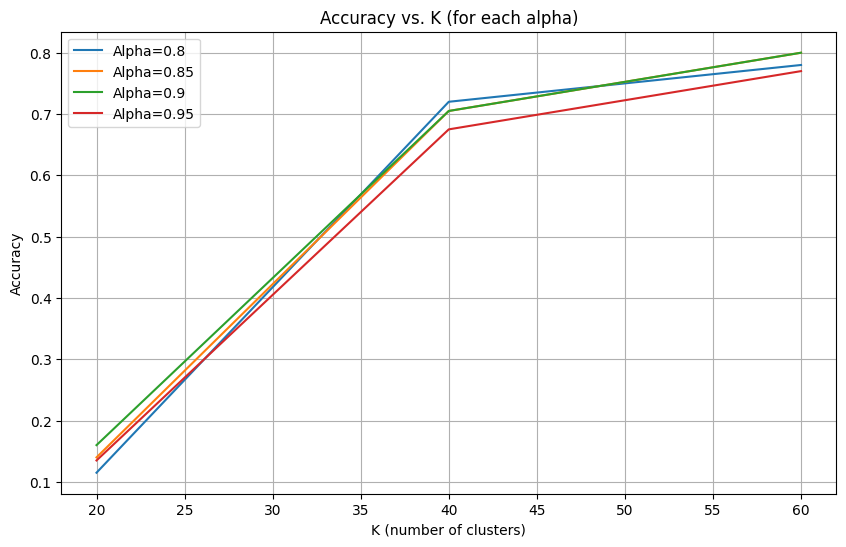

In [31]:
# Plot accuracy for different K values for each alpha
plt.figure(figsize=(10, 6))

for alpha in accuracy_results:
    ks = list(accuracy_results[alpha].keys())
    accuracies = list(accuracy_results[alpha].values())
    plt.plot(ks, accuracies, label=f'Alpha={alpha}')

plt.xlabel('K (number of clusters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K (for each alpha)')
plt.legend()
plt.grid(True)
plt.show()

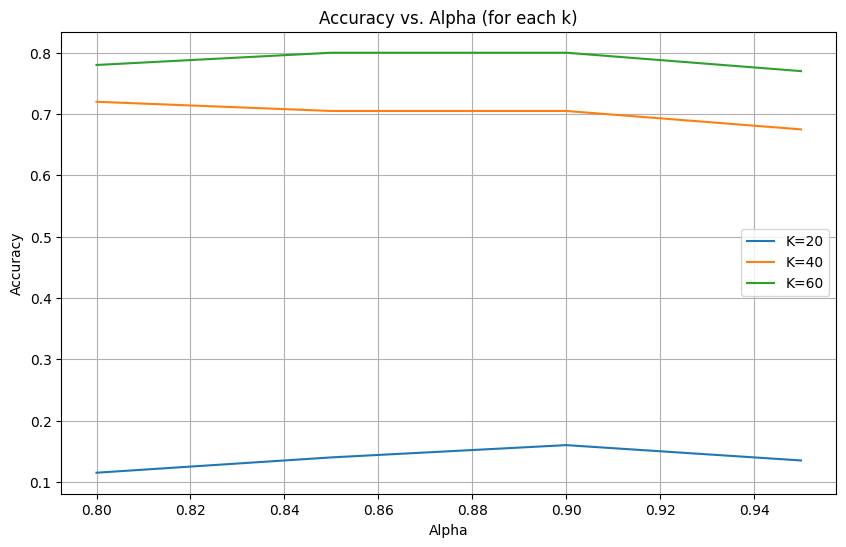

In [32]:
# Plot accuracy for different alpha values for each k
plt.figure(figsize=(10, 6))

for k in accuracy_results[next(iter(accuracy_results))]:  # Assuming k exists for all alphas
    alphas = list(accuracy_results.keys())  # List of alpha values
    accuracies = [accuracy_results[alpha][k] for alpha in alphas]  # Accuracy for each alpha for this k
    plt.plot(alphas, accuracies, label=f'K={k}')

plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha (for each k)')
plt.legend()
plt.grid(True)
plt.show()

## Training using autoencoder

In [33]:
# Convert the data into torch tensors
X_train_tensor = torch.FloatTensor(X_train) / 255.0  # Normalize (important!)
X_test_tensor = torch.FloatTensor(X_test) / 255.0

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



## train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder(input_dim=10304, latent_dim=100).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 50
autoencoder.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        
        optimizer.zero_grad()
        outputs, _ = autoencoder(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.6f}")

Epoch 1/50, Loss: 0.034100
Epoch 2/50, Loss: 0.027624
Epoch 3/50, Loss: 0.024782
Epoch 4/50, Loss: 0.024105
Epoch 5/50, Loss: 0.024082
Epoch 6/50, Loss: 0.022727
Epoch 7/50, Loss: 0.022578
Epoch 8/50, Loss: 0.022485
Epoch 9/50, Loss: 0.021330
Epoch 10/50, Loss: 0.019724
Epoch 11/50, Loss: 0.019414
Epoch 12/50, Loss: 0.018548
Epoch 13/50, Loss: 0.018211
Epoch 14/50, Loss: 0.017441
Epoch 15/50, Loss: 0.017303
Epoch 16/50, Loss: 0.017431
Epoch 17/50, Loss: 0.017702
Epoch 18/50, Loss: 0.016730
Epoch 19/50, Loss: 0.016224
Epoch 20/50, Loss: 0.015707
Epoch 21/50, Loss: 0.015067
Epoch 22/50, Loss: 0.015242
Epoch 23/50, Loss: 0.014487
Epoch 24/50, Loss: 0.014197
Epoch 25/50, Loss: 0.014185
Epoch 26/50, Loss: 0.013828
Epoch 27/50, Loss: 0.013428
Epoch 28/50, Loss: 0.013223
Epoch 29/50, Loss: 0.012522
Epoch 30/50, Loss: 0.012591
Epoch 31/50, Loss: 0.012138
Epoch 32/50, Loss: 0.012215
Epoch 33/50, Loss: 0.011679
Epoch 34/50, Loss: 0.011532
Epoch 35/50, Loss: 0.011328
Epoch 36/50, Loss: 0.011167
E

In [34]:
autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor.to(device))
    _, X_test_latent = autoencoder(X_test_tensor.to(device))

# Move to CPU and convert to numpy
X_train_latent = X_train_latent.cpu().numpy()
X_test_latent = X_test_latent.cpu().numpy()

In [35]:
clusters = [20, 40, 60]

# Structure: {k: model}
kmeans_models = {}

for k in clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_latent, y_train)
    kmeans_models[k] = kmeans

model = kmeans_models[40]
print(f"At k=40 cluster labels:\n{model.labels}")

At k=40 cluster labels:
[10 20 24 23  5 28 34 38 38 19 21 36 16 13 22  7  1 12 19 34  3 23 20 37
 34 11 19 21 15 21 22 30 16 13  3  8 16  2  3 18 13 12 37 18 38 12  5 20
  6 39 23 38 39  5 28  5  6 10 38 38 16 10 24 12 37 37 18 22 28  2 33 15
 25 18 14  7 25  2  8  7 16 18  8 22 34 33  3 14 34 11 18  6  8 24  3 34
  5 39 25  3 32 24  6 20  5  6 12 11  7 30 16 32 12  3 13 38 14  5  3 25
 18  5 30 38  3 18  7 30  8 37 16  8 37 25 18  2 32  5 33 21  7  7 22 19
 19 24 39  7 28 19  7  7 30 22 25  1 38 21 20 25 38 21 16  7 11 33 18 33
 12 32 19 33 18  1 25 34 15 14  5 34 16 33 39 21  3  8 10 15 30  5 38 12
 18 22 13 18 28 37 38  8]


## Validation using autoencoder

In [36]:
predictions = {}

for k, model in kmeans_models.items():
        y_pred = model.predict(X_train_latent)
        predictions[k] = y_pred

## Evaluation on validation data using autoencpder

k: 20:
Accuracy: 0.03
F1-Score: 0.00


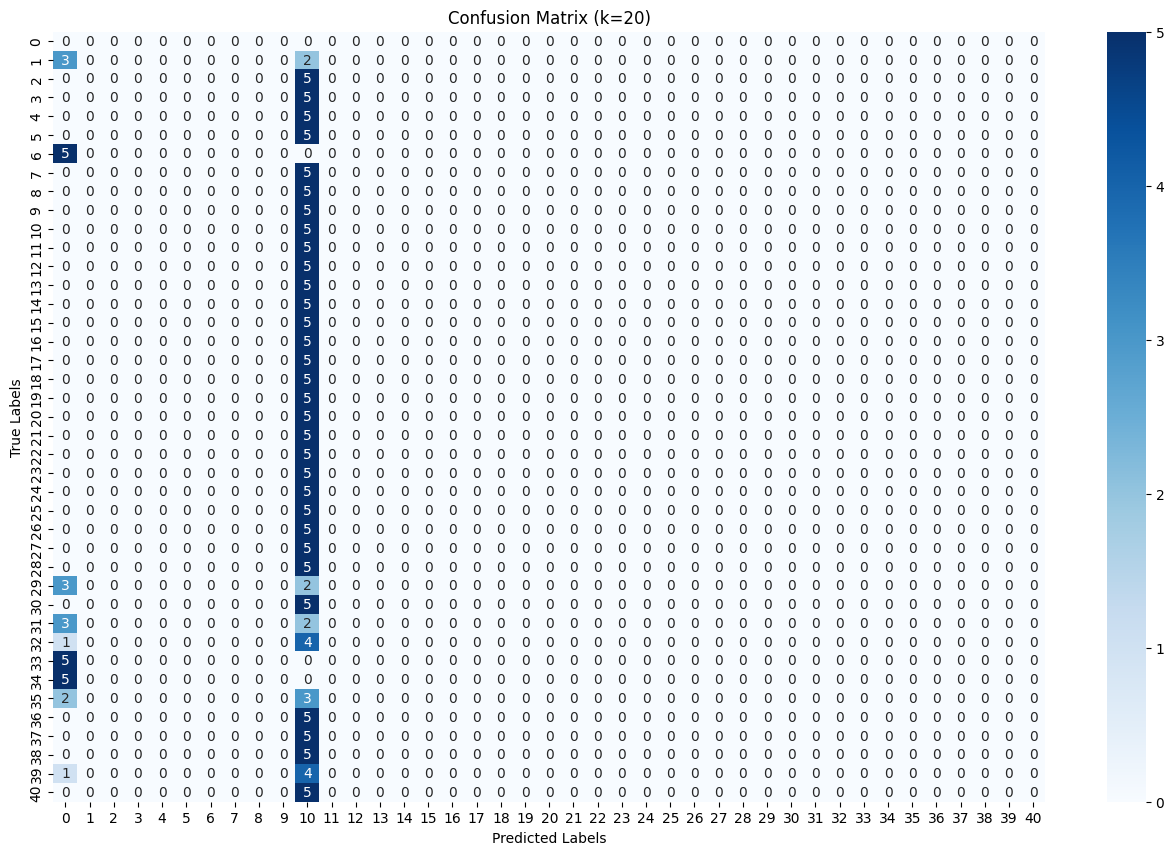

k: 40:
Accuracy: 0.56
F1-Score: 0.50


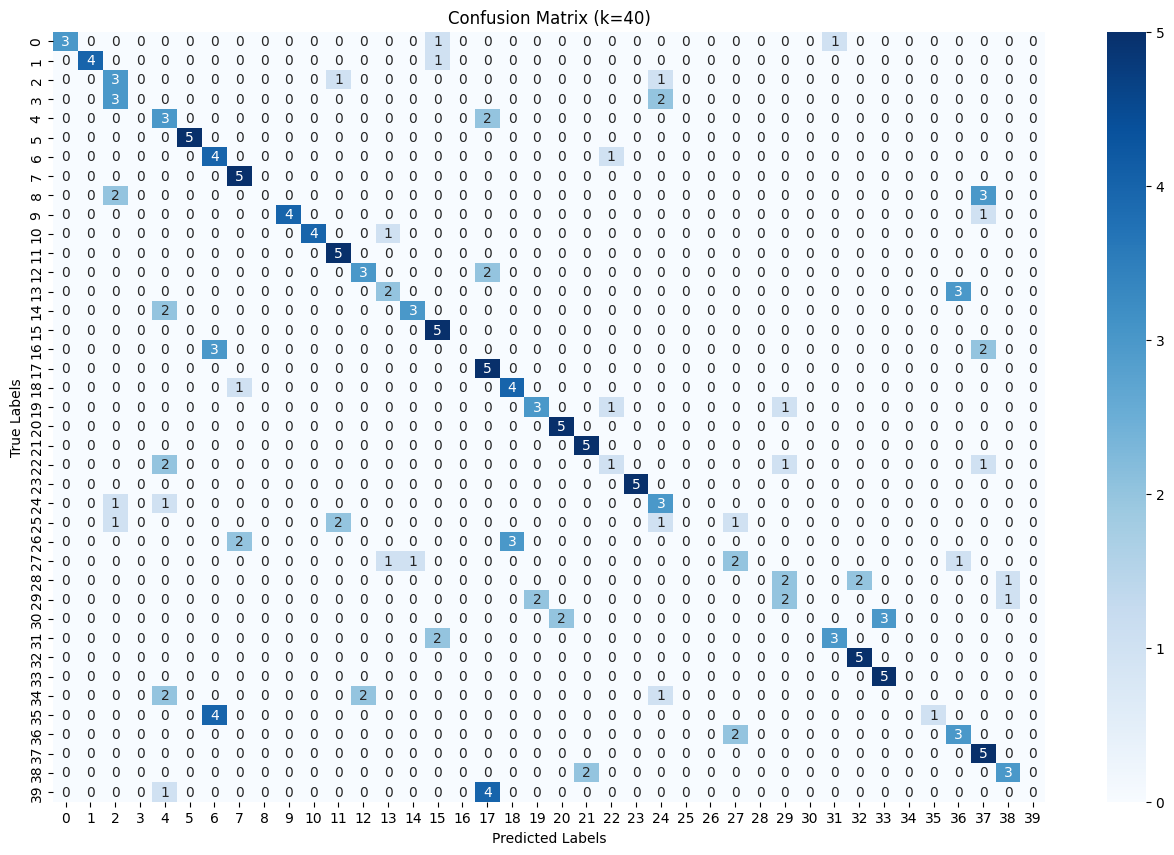

k: 60:
Accuracy: 0.67
F1-Score: 0.64


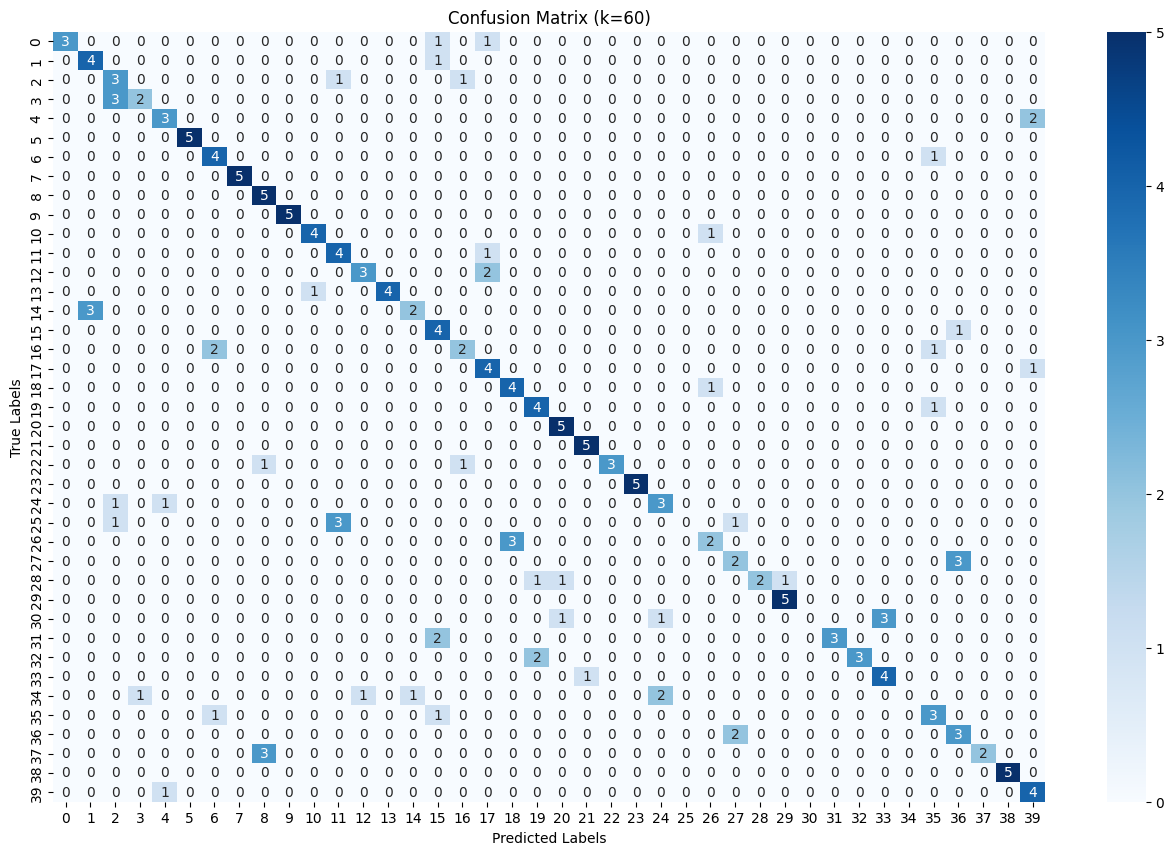

In [37]:
accuracy_results = {}

for k, y_pred in predictions.items():
    acc = accuracy_score(y_train, y_pred)
    accuracy_results[k] = acc
    
    f1 = f1_score(y_train, y_pred, average='macro')  # 'macro' for multiclass
    
    cm = confusion_matrix(y_train, y_pred)

    print(f"k: {k}:")

    # Accuracy
    print(f"Accuracy: {acc:.2f}")
    
    # F1-score
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    plt.figure(figsize=(16, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (k={k})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [38]:
# Flatten the dictionary into a list of results
results = []
for k, acc in accuracy_results.items():
    results.append({'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    k  accuracy
0  20     0.025
1  40     0.565
2  60     0.665


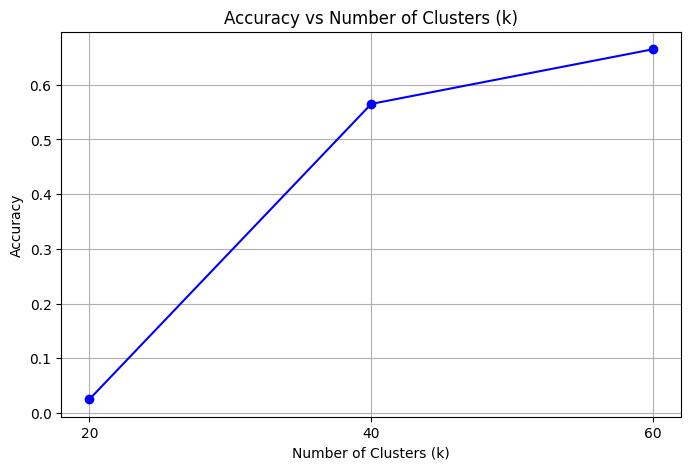

In [39]:
# Plot accuracy for different K values
sorted_k = sorted(accuracy_results.keys())
accuracies = [accuracy_results[k] for k in sorted_k]

plt.figure(figsize=(8, 5))
plt.plot(sorted_k, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(sorted_k)
plt.show()

## Testing using autoencoder

In [40]:
predictions = {}

for k, model in kmeans_models.items():
        y_pred = model.predict(X_test_latent)
        predictions[k] = y_pred

## Evaluation on test using autoencoder

k: 20:
Accuracy: 0.03
F1-Score: 0.00


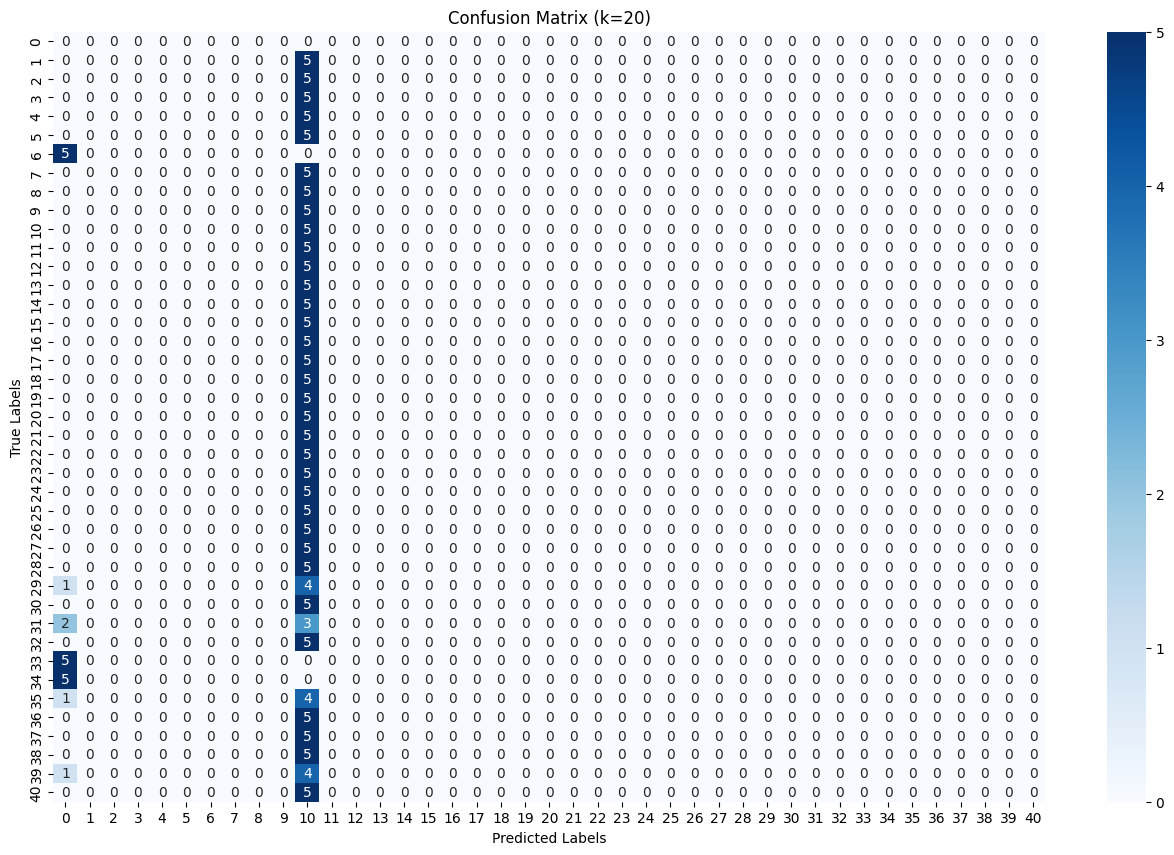

k: 40:
Accuracy: 0.47
F1-Score: 0.41


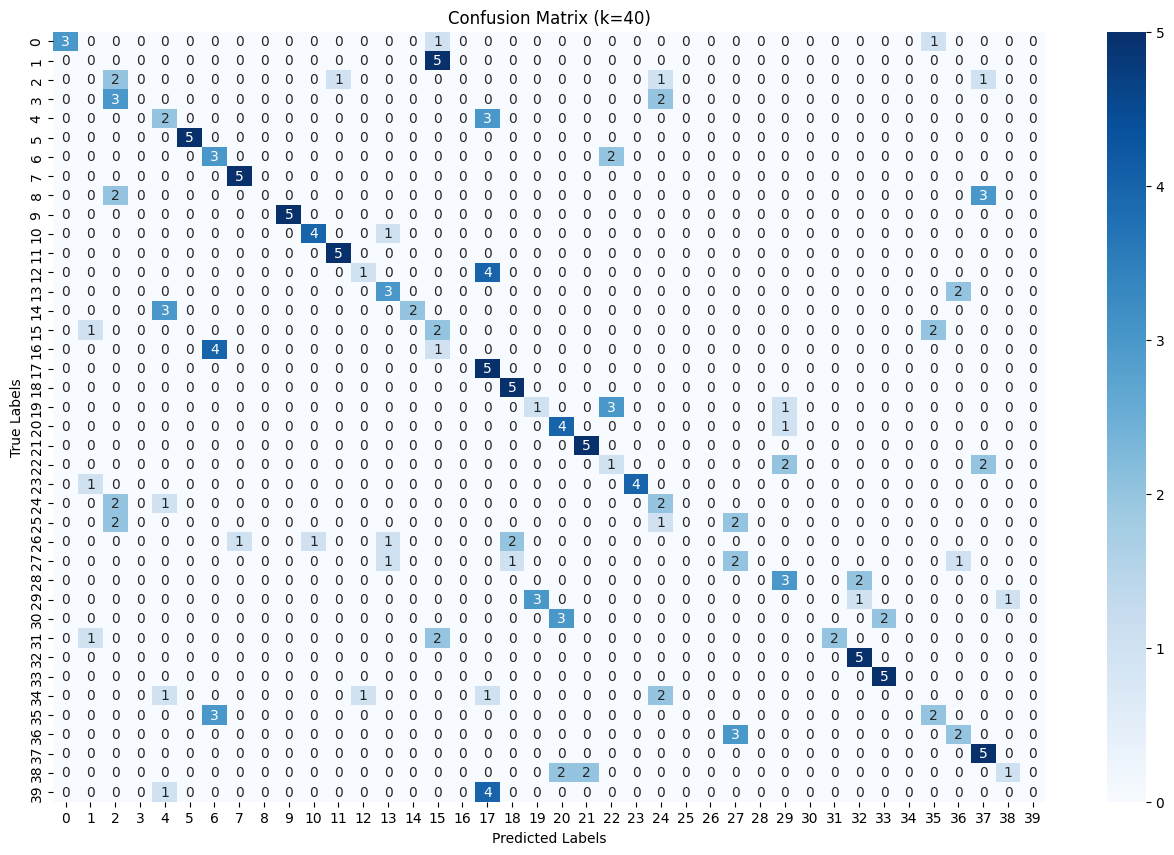

k: 60:
Accuracy: 0.54
F1-Score: 0.53


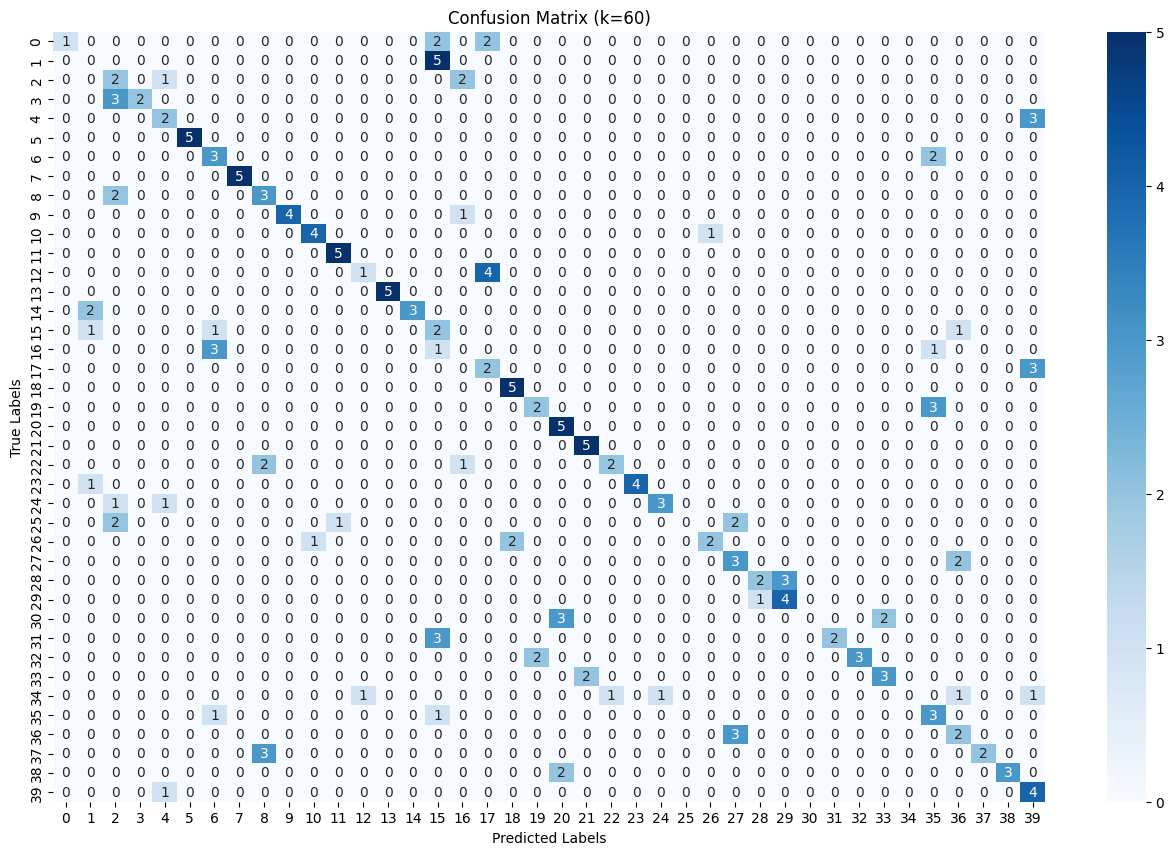

In [41]:
accuracy_results = {}

for k, y_pred in predictions.items():
    acc = accuracy_score(y_test, y_pred)
    accuracy_results[k] = acc
    
    f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
    
    cm = confusion_matrix(y_test, y_pred)

    print(f"k: {k}:")

    # Accuracy
    print(f"Accuracy: {acc:.2f}")
    
    # F1-score
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    plt.figure(figsize=(16, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (k={k})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [42]:
# Flatten the dictionary into a list of results
results = []
for k, acc in accuracy_results.items():
    results.append({'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    k  accuracy
0  20     0.025
1  40     0.465
2  60     0.540


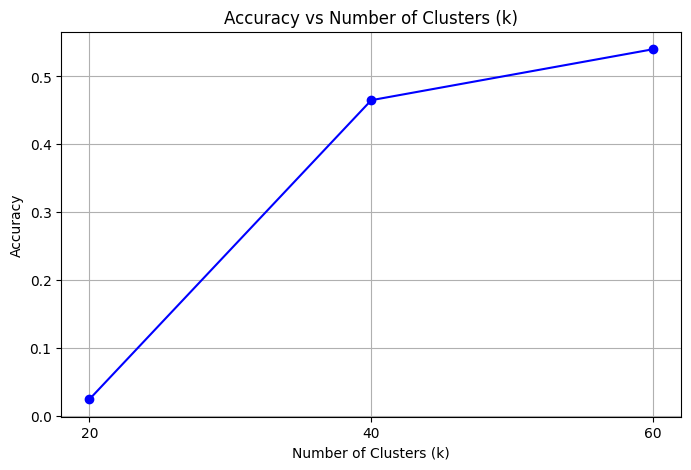

In [43]:
# Plot accuracy for different K values
sorted_k = sorted(accuracy_results.keys())
accuracies = [accuracy_results[k] for k in sorted_k]

plt.figure(figsize=(8, 5))
plt.plot(sorted_k, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(sorted_k)
plt.show()

# GMM

In [44]:
class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_params(self, X):
        self.N, self.M = X.shape

        # K-means initialization
        kmeans = KMeans(n_clusters=self.K, n_init=5).fit(X)
        self.means = kmeans.cluster_centers_

        # Initialize responsibilities
        self.r = np.zeros((self.N, self.K))
        self.r[np.arange(self.N), kmeans.labels_] = 1

        # Initialize mixing coefficients
        self.weights = np.bincount(kmeans.labels_, minlength=self.K) / self.N

        # Initialize diagonal covariances
        self.covs = np.zeros((self.K, self.M))
        for k in range(self.K):
            cluster_data = X[kmeans.labels_ == k]
            if len(cluster_data) > 1:
                self.covs[k] = np.var(cluster_data, axis=0)
            else:
                self.covs[k] = np.ones(self.M)
            self.covs[k] += 1e-6  # Regularization

    def _expectation_step(self, X):
        log_prob = np.zeros((self.N, self.K))

        for k in range(self.K):
            try:
                # Create diagonal covariance matrix
                cov_matrix = np.diag(self.covs[k])
                rv = multivariate_normal(self.means[k], cov_matrix, allow_singular=True)
                log_prob[:, k] = np.log(self.weights[k] + 1e-10) + rv.logpdf(X)
            except:
                log_prob[:, k] = -np.inf

        # Log-sum-exp trick
        log_r = log_prob - logsumexp(log_prob, axis=1, keepdims=True)
        self.r = np.exp(log_r)

    def _maximization_step(self, X):
        Nk = np.sum(self.r, axis=0)

        # Update weights
        self.weights = Nk / self.N

        # Update means
        self.means = (self.r.T @ X) / Nk[:, None]

        # Update diagonal covariances
        for k in range(self.K):
            diff = X - self.means[k]
            self.covs[k] = np.sum(self.r[:, k, None] * (diff ** 2), axis=0) / Nk[k]
            self.covs[k] += 1e-6  # Regularization

    def _compute_log_likelihood(self, X):
        log_prob = np.zeros((self.N, self.K))
        for k in range(self.K):
            try:
                cov_matrix = np.diag(self.covs[k])
                rv = multivariate_normal(self.means[k], cov_matrix, allow_singular=True)
                log_prob[:, k] = np.log(self.weights[k] + 1e-10) + rv.logpdf(X)
            except:
                log_prob[:, k] = -np.inf
        return np.sum(logsumexp(log_prob, axis=1))

    def fit(self, X, y_train):
        self._initialize_params(X)
        prev_ll = -np.inf

        for i in range(self.max_iter):
            self._expectation_step(X)
            self._maximization_step(X)

            current_ll = self._compute_log_likelihood(X)
            if np.abs(current_ll - prev_ll) < self.tol:
                break
            prev_ll = current_ll

        self._create_cluster_map(X, y_train)
        return self

    def _create_cluster_map(self, X, y):
        clusters = self.predict(X)
        self.cluster_map_ = {}

        for k in range(self.K):
            mask = (clusters == k)
            if np.any(mask):
                self.cluster_map_[k] = np.argmax(np.bincount(y[mask]))
            else:
                self.cluster_map_[k] = 0
        return self

    def predict_proba(self, X):

        log_prob = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            try:
                cov_matrix = np.diag(self.covs[k])
                rv = multivariate_normal(self.means[k], cov_matrix, allow_singular=True)
                log_prob[:, k] = np.log(self.weights[k] + 1e-10) + rv.logpdf(X)
            except:
                log_prob[:, k] = -np.inf

        log_prob -= logsumexp(log_prob, axis=1, keepdims=True)
        return np.exp(log_prob)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y):
        y_pred = np.array([self.cluster_map_[c] for c in self.predict(X)])
        return accuracy_score(y, y_pred)

## Train, Evaluate and Test using PCA

In [ ]:
K_values = [20, 40, 60]
alpha_values = [0.8, 0.85, 0.9, 0.95]

results = []

for K in K_values:
    for alpha in alpha_values:
        print(f"\n{'='*50}")
        print(f"Training GMM with K={K}, α={alpha}")
        print(f"{'='*50}")

        # Apply PCA
        pca = PCA(alpha=alpha)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train GMM
        gmm = GMM(n_components=K)
        gmm.fit(X_train_pca, y_train)

        test_acc = gmm.score(X_test_pca, y_test)
        y_pred_test = np.array([gmm.cluster_map_[c] for c in gmm.predict(X_test_pca)])

        # Calculate metrics
        f1_test = f1_score(y_test, y_pred_test, average='weighted')
        cm_test = confusion_matrix(y_test, y_pred_test)

        # Print results
        print(f"\nMetrics:")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1: {f1_test:.4f}")
        print("\nTest Confusion Matrix:")
        print(cm_test)

## Train, Evaluate and Test using autoencoder

In [ ]:
for K in K_values:
      print(f"\n{'='*50}")
      print(f"Training GMM with K={K}")
      print(f"{'='*50}")

      # Train GMM
      gmm = GMM(n_components=K)
      gmm.fit(X_train_latent, y_train)

      # Evaluate
      test_acc = gmm.score(X_test_latent, y_test)

      # Get predictions
      y_pred_test = np.array([gmm.cluster_map_[c] for c in gmm.predict(X_test_latent)])

      # Calculate metrics
      f1_test = f1_score(y_test, y_pred_test, average='weighted')
      cm_test = confusion_matrix(y_test, y_pred_test)

      # Print results
      print(f"\nMetrics:")
      print(f"Test Accuracy: {test_acc:.4f}")
      print(f"Test F1: {f1_test:.4f}")

      print("\nTest Confusion Matrix:")
      print(cm_test)